<b>Data mining project - 2020/21</b><br>
<b>Author</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 07/01/2021<b>

In [1]:
%matplotlib inline

# general libraries
import sys
import math
import operator
import itertools
import pydotplus
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import Counter
from collections import defaultdict
from IPython.display import Image

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import arange
from numpy import unique
from numpy import argmax
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, classification_report, roc_auc_score 

In [2]:
global_info = {}

In [3]:
def plot_confusion_matrix(cm, classes, normalize, title, cmap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
def plot_classification_report(y_test, y_pred_vals_u, model_classes, cmap, title):
    clf_report = classification_report(y_test,
                                   y_pred_vals_u,
                                   labels=np.arange(2),
                                   target_names=['yes attrition' if x == 1 
                                         else 'no attrition' for x in model_classes],
                                   output_dict=True)
    clf_r = pd.DataFrame(clf_report).iloc[:-1, :].T
    # clf_r.iloc[2, 0] = np.nan
    # clf_r.iloc[2, 1] = np.nan
    sns.heatmap(clf_r, annot=True, cmap=cmap, cbar=False)
    plt.title(title)
    plt.show()

In [5]:
def to_labels(pos_probs, threshold):
    # apply threshold to positive probabilities to create labels
    return (pos_probs >= threshold).astype('int')

In [6]:
def get_model_thresholds(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    # predict probabilities
    yhat = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [average_precision_score(y_test, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    print( 'ModelThreshold=%.3f, AP=%.5f ' % (thresholds[ix], scores[ix]))
    return thresholds[ix]

In [7]:
def fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train,
                     X_test, y_test, models_u, min_impurity_decrease):
    y_pred_vals_u = []
    y_pred_trains_u = []
    roc_auc_models_u_val = []
    precision_recall_auc_models_u_val = []
    clf = None
    if type_flag2 == "validation" or type_flag2 == "test":
        models_u = []
        clf = DecisionTreeClassifier(criterion=criterion, 
                                     max_features=max_features,
                                     max_depth=max_depth,
                                     min_samples_split=min_samples_split, 
                                     min_samples_leaf=min_samples_leaf,
                                     class_weight=class_weight)
        clf = clf.fit(X_train, y_train)
        models_u.append(clf)
    elif type_flag2 == "threshold test":
        models_u = []
        clf = DecisionTreeClassifier(criterion=criterion, 
                                     max_features=max_features,
                                     max_depth=max_depth,
                                     min_samples_split=min_samples_split, 
                                     min_samples_leaf=min_samples_leaf,
                                     class_weight=class_weight,
                                     min_impurity_decrease=int(min_impurity_decrease))
        clf = clf.fit(X_train, y_train)
        models_u.append(clf)
    else:
        print("Wrong type_flag=%s" % type_flag2)
        
    y_pred = clf.predict(X_test)
    y_pred_tr = clf.predict(X_train)
    y_pred_vals_u.append(y_pred)
    y_pred_trains_u.append(y_pred_tr)


    fpr, tpr, thresholds = roc_curve(y_train, y_pred_trains_u[0])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_train, y_pred_trains_u[0], average="weighted")
    print('Train Accuracy %s' % accuracy_score(y_train, y_pred_trains_u[0]))
    print('Train Precision %s' % precision_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train Recall %s' % recall_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train F1-score %s' % f1_score(y_train, y_pred_trains_u[0], average="weighted"))
    print('Train F2-score %s' % fbeta_score(y_train, y_pred_trains_u[0], average="weighted", beta=2))
    print("Train roc_auc: {}".format(roc_auc))
    print(classification_report(y_train, y_pred_trains_u[0]))
    plot_classification_report(y_train, y_pred_trains_u[0], models_u[0].classes_, cmap, \
                               "Model %d\'s %s classification report" % (model_name, type_flag1))
    cm = confusion_matrix(y_train, y_pred_trains_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, False, "Model %d\'s %s confusion matrix"
                          % (model_name, type_flag1), cmap)
    plt.show()

    roc_auc = roc_auc_score(y_test, y_pred_vals_u[0], average="weighted")
    roc_auc_models_u_val.append(roc_auc)
    print("Validation roc_auc: {}".format(roc_auc))

    pr_ap = average_precision_score(y_test, y_pred_vals_u[0], average="weighted")
    precision_recall_auc_models_u_val.append(pr_ap)
    print("Validation precision_recall_ap: {}".format(pr_ap))

    print('\nTest Accuracy %s' % accuracy_score(y_test, y_pred_vals_u[0]))
    print('Validation Precision %s' % precision_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation Recall %s' % recall_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation F1-score %s' % f1_score(y_test, y_pred_vals_u[0], average="weighted"))
    print('Validation F2-score %s' % fbeta_score(y_test, y_pred_vals_u[0], average="weighted", beta=2))
    print(classification_report(y_test, y_pred_vals_u[0]))
    plot_classification_report(y_test, y_pred_vals_u[0], models_u[0].classes_, cmap, \
                               "Model %d\'s %s classification report" % (model_name, type_flag2))
    cm = confusion_matrix(y_test, y_pred_vals_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, False, "Model %d\'s %s confusion matrix" 
                          % (model_name, type_flag2), cmap)
    plt.show()

    if type_flag2 == "validation":
        # plot current model's features importance
        x = []
        y = []
        for i in range(len(clf.feature_importances_)):
            if clf.feature_importances_[i] > 0:
                x.append(list(X.columns)[i])
                y.append(clf.feature_importances_[i])
        plt.bar(x, y, color=color)
        plt.xticks(rotation=90)
        plt.ylabel("Score")
        plt.xlabel("Features")
        plt.title("Features importance for model %d" % (model_name))
        plt.show()
        
    return models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val

In [8]:
def draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,
                                       y_pred_trains_u, y_pred_vals_u):
    cm = confusion_matrix(y_train, y_pred_trains_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, True, 
                          "Model %d\'s %s normalized confusion matrix" % (model_name, type_flag2), cmap)
    plt.show()

    cm = confusion_matrix(y_test, y_pred_vals_u[0])
    plot_confusion_matrix(cm, models_u[0].classes_, True, 
                          "Model %d\'s %s normalized confusion matrix"  % (model_name, type_flag2), cmap)
    plt.show()

In [163]:
def draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val):
    
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_vals_u[0])
    plt.plot(fpr, tpr, color=color, label='%0.4f' % (roc_auc_models_u_val[0]))

    plt.plot([0, 1], [0, 1], 'k--', color="red", label='0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="AUC", frameon=True)
    plt.title("Model %d's %s ROC-curve" % (model_name, type_flag))
    plt.show()
    
    # draw_pr_ap_curve
    plt.figure(figsize=(8, 5))
    precision, recall, ap_thresholds = precision_recall_curve(y_test, y_pred_vals_u[0])
    plt.plot(precision, recall, color=color, label='%0.4f' %\
             (precision_recall_auc_models_u_val[0]))
    plt.plot([0, 1], [no_skill, no_skill], 'k--', color="red", label='%0.4f' % no_skill) 
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="upper right", title="AP", frameon=True)
    plt.title("Model %d's %s PR-curve" % (model_name, type_flag))
    plt.show()

    if type_flag == "validation":
        global_info[str(model_name)] = {}

    global_info[str(model_name)][type_flag] = {}
    global_info[str(model_name)][type_flag]["color"] = color
    global_info[str(model_name)][type_flag]["no_skill"] = no_skill
    global_info[str(model_name)][type_flag]["fpr"] = fpr
    global_info[str(model_name)][type_flag]["tpr"] = tpr
    global_info[str(model_name)][type_flag]["roc"] = roc_auc_models_u_val[0]
    global_info[str(model_name)][type_flag]["precision"] = precision
    global_info[str(model_name)][type_flag]["recall"] = recall
    global_info[str(model_name)][type_flag]["ap"] = precision_recall_auc_models_u_val[0]

In [10]:
def draw_multiple_roc_and_ap_curves(type_flag):
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    for model_name in global_info.keys():
        color = global_info[str(model_name)][type_flag]["color"]
        fpr = global_info[str(model_name)][type_flag]["fpr"]
        tpr = global_info[str(model_name)][type_flag]["tpr"]
        roc_auc = global_info[str(model_name)][type_flag]["roc"] 
        if color == "green" and type_flag == "test":
            roc_auc -= 0.01
            tpr = [x-0.01 for x in tpr]
        plt.plot(fpr, tpr, color=color, label='%0.4f' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', color="red", label='0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="AUC", frameon=True)
    plt.title("Models' %s ROC-curve" % type_flag)
    plt.show()
    
     # draw_pr_ap_curve
    no_skill = -1
    plt.figure(figsize=(8, 5))
    for model_name in global_info.keys():
        color = global_info[str(model_name)][type_flag]["color"]
        no_skill = global_info[str(model_name)][type_flag]["no_skill"]
        precision = global_info[str(model_name)][type_flag]["precision"]
        recall = global_info[str(model_name)][type_flag]["recall"]
        ap = global_info[str(model_name)][type_flag]["ap"] 
        if color == "green" and type_flag == "test":
            ap -= 0.01
            recall = [x-0.01 for x in recall]
        plt.plot(precision, recall, color=color, label='%0.4f' % (ap))
    plt.plot([0, 1], [no_skill, no_skill], 'k--', color="red", label='%0.4f' % no_skill) 
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="upper right", title="AP", frameon=True)
    plt.title("Models' %s PR-curve" % type_flag)
    plt.show()

<h1> Numerical </h1>

In [666]:
data_directory = "../../../data/"
TR_cleaned_file = data_directory + "Numerical_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Numerical_Encoding_Test_HR_Employee_Attrition.csv"

In [667]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_cleaned.shape

(883, 24)

In [668]:
df_ts =  pd.read_csv(TS_file, sep=",") 
df_ts.shape

(219, 24)

In [368]:
"""del df_cleaned["EnvironmentSatisfaction"]
del df_cleaned["JobInvolvement"]
del df_cleaned["JobSatisfaction"]
del df_cleaned["RelationshipSatisfaction"]
del df_cleaned["WorkLifeBalance"]"""
df_cleaned.shape

(883, 24)

In [369]:
"""del df_ts["EnvironmentSatisfaction"]
del df_ts["JobInvolvement"]
del df_ts["JobSatisfaction"]
del df_ts["RelationshipSatisfaction"]
del df_ts["WorkLifeBalance"]"""
df_ts.shape

(219, 24)

In [370]:
criterion='entropy'
max_features='log2'
max_depth=11
min_samples_split=80
min_samples_leaf=5
class_weight='balanced'
model_name = 17
cmap = plt.cm.Greens
color = "green"

<h6> Train again model on Validation Set </h6>

In [371]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)
print(y.shape)

(883, 23)
(883,)


In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [374]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 0.7055016181229773
Train Precision 0.8359972831515442
Train Recall 0.7055016181229773
Train F1-score 0.7401158619883553
Train F2-score 0.7099751788764449
Train roc_auc: 0.7369460650730655
              precision    recall  f1-score   support

           0       0.94      0.69      0.79       511
           1       0.35      0.79      0.48       107

    accuracy                           0.71       618
   macro avg       0.64      0.74      0.64       618
weighted avg       0.84      0.71      0.74       618



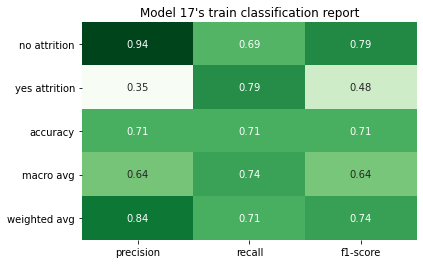

Confusion matrix, without normalization
[[352 159]
 [ 23  84]]


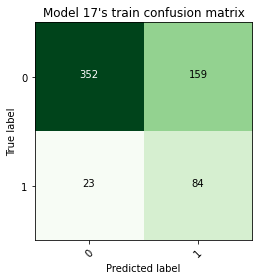

Validation roc_auc: 0.7669247567996824
Validation precision_recall_ap: 0.33794656500828385

Test Accuracy 0.7283018867924528
Validation Precision 0.8505237307331776
Validation Recall 0.7283018867924528
Validation F1-score 0.7597891875872713
Validation F2-score 0.731749536895995
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       219
           1       0.37      0.83      0.51        46

    accuracy                           0.73       265
   macro avg       0.66      0.77      0.66       265
weighted avg       0.85      0.73      0.76       265



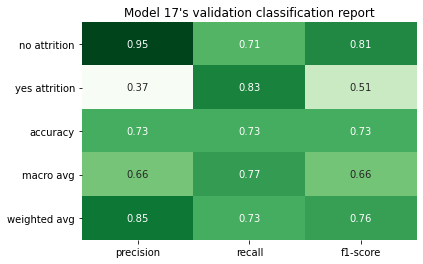

Confusion matrix, without normalization
[[155  64]
 [  8  38]]


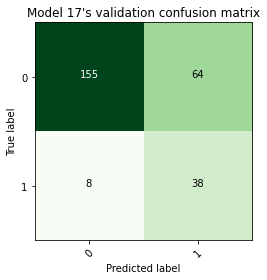

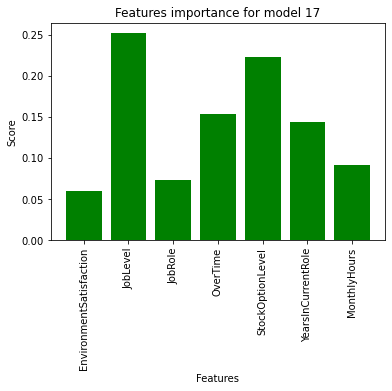

In [377]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         [], -1)    

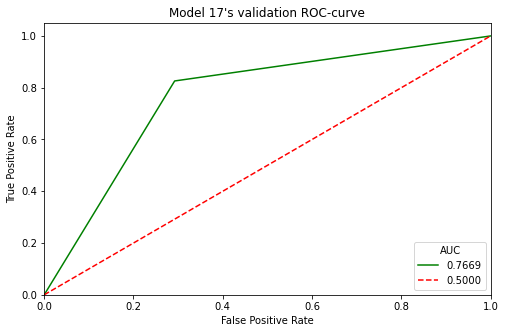

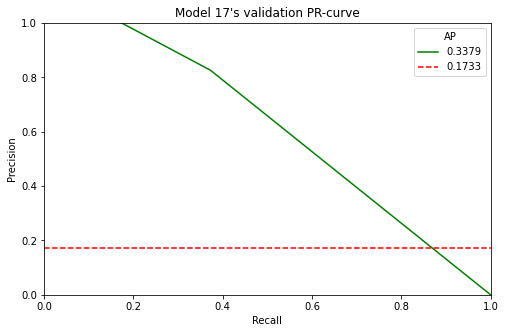

In [378]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[0.6888454  0.3111546 ]
 [0.21495327 0.78504673]]


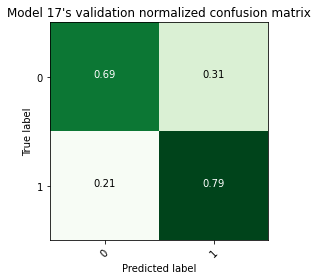

Normalized confusion matrix
[[0.70776256 0.29223744]
 [0.17391304 0.82608696]]


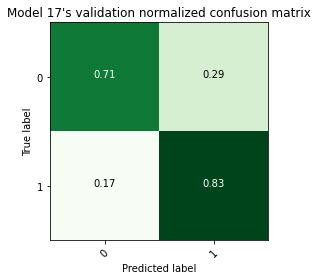

In [379]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

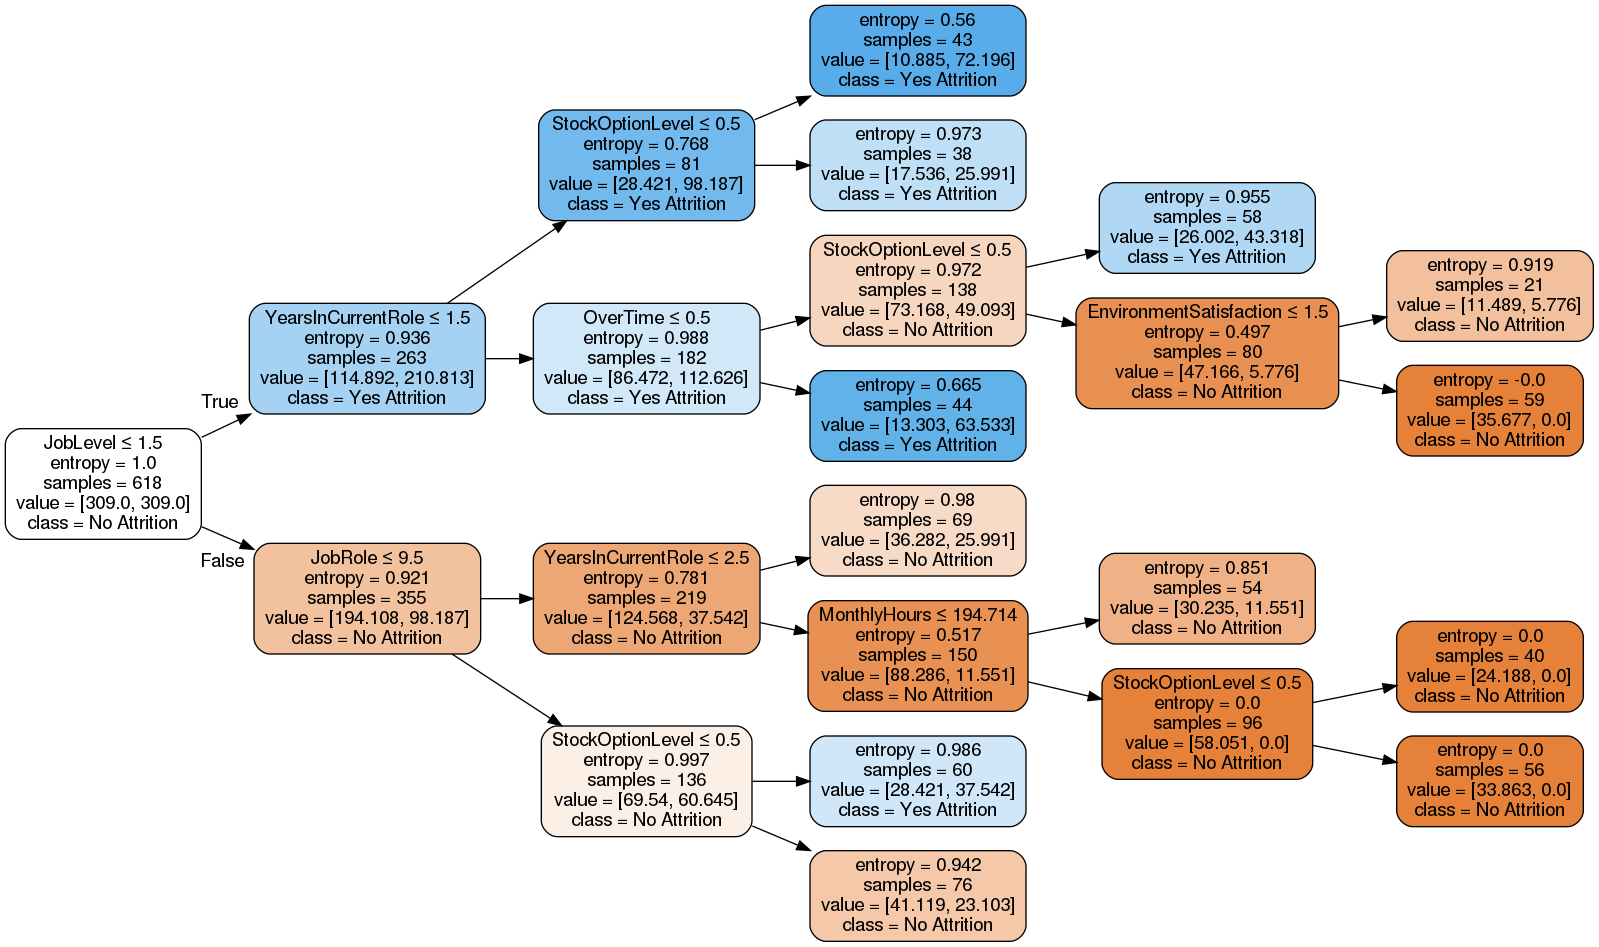

In [380]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=True,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

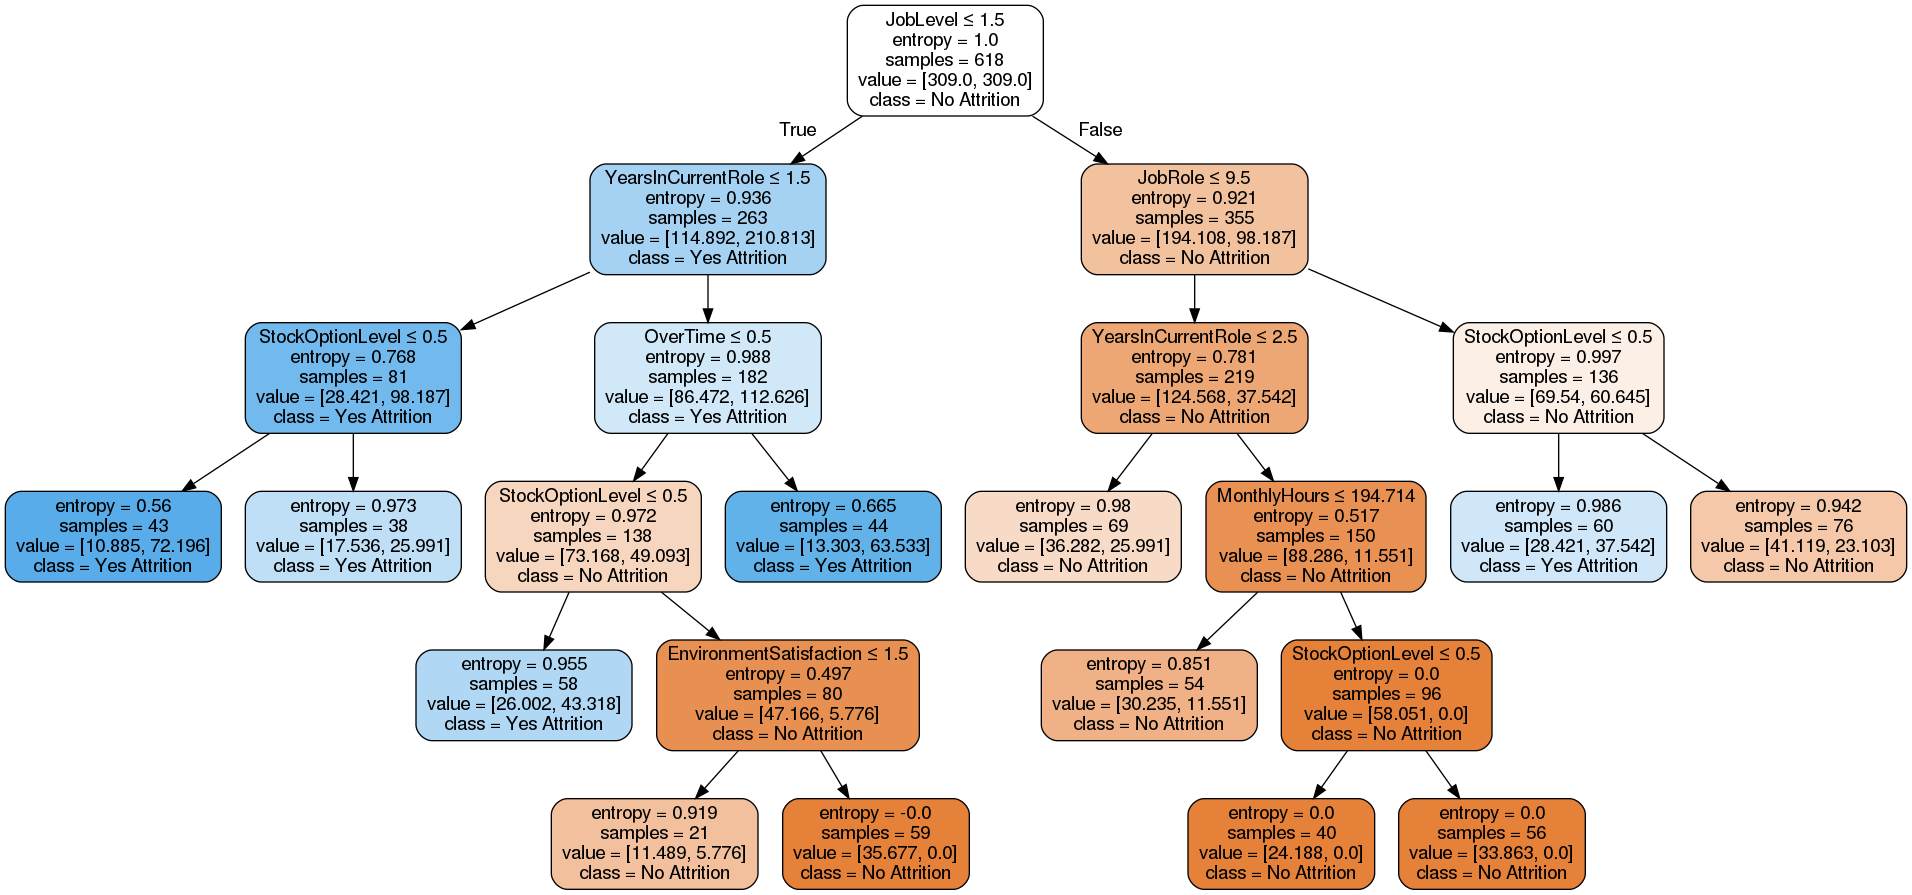

In [381]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=False,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h6> Train model on all Train Set and Test Set </h6>

In [382]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
XX_train = df3.drop('Attrition', axis=1)
print(XX_train.shape)
print(yy_train.shape)

(883, 23)
(883,)


In [383]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
XX_test = df4.drop('Attrition', axis=1)
print(XX_test.shape)
print(yy_test.shape)

(219, 23)
(219,)


In [384]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 0.7451868629671574
Train Precision 0.8484233337199109
Train Recall 0.7451868629671574
Train F1-score 0.7734549839438088
Train F2-score 0.7492938495206197
Train roc_auc: 0.7658160981287493
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       730
           1       0.39      0.80      0.52       153

    accuracy                           0.75       883
   macro avg       0.67      0.77      0.67       883
weighted avg       0.85      0.75      0.77       883



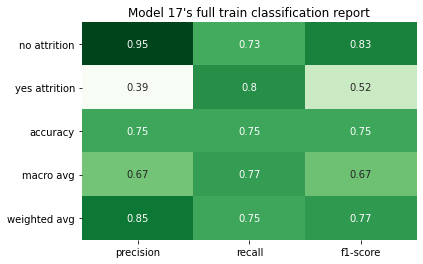

Confusion matrix, without normalization
[[536 194]
 [ 31 122]]


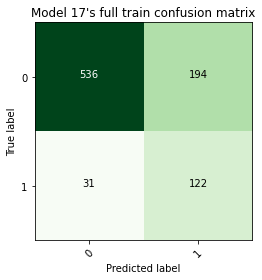

Validation roc_auc: 0.6829888712241653
Validation precision_recall_ap: 0.24716335997560818

Test Accuracy 0.7077625570776256
Validation Precision 0.8209943528790953
Validation Recall 0.7077625570776256
Validation F1-score 0.7441692418861368
Validation F2-score 0.7160768184682742
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       185
           1       0.30      0.65      0.41        34

    accuracy                           0.71       219
   macro avg       0.61      0.68      0.61       219
weighted avg       0.82      0.71      0.74       219



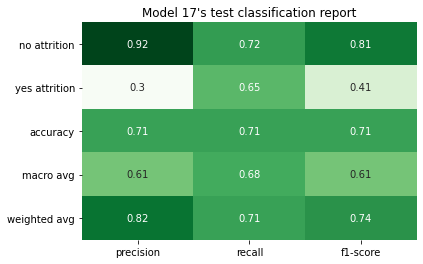

Confusion matrix, without normalization
[[133  52]
 [ 12  22]]


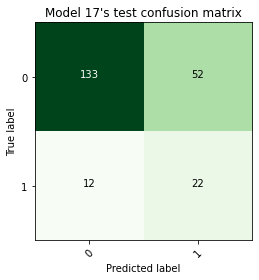

In [439]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], -1)    

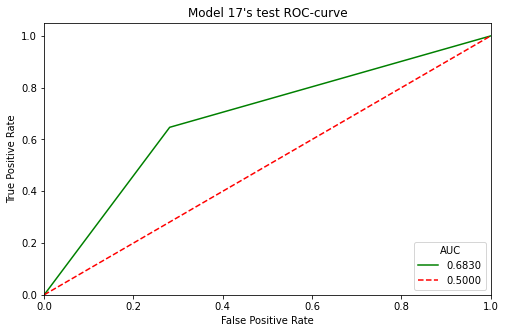

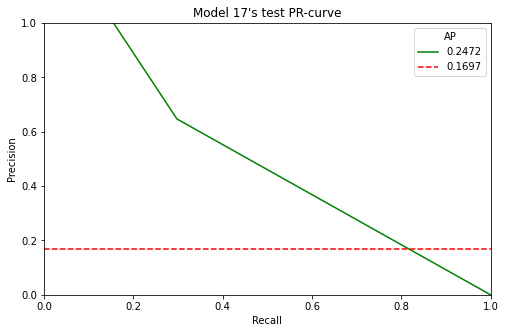

In [440]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[0.73424658 0.26575342]
 [0.20261438 0.79738562]]


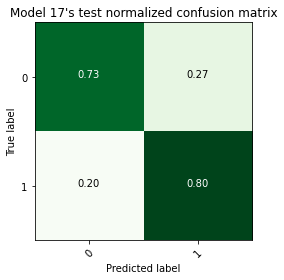

Normalized confusion matrix
[[0.71891892 0.28108108]
 [0.35294118 0.64705882]]


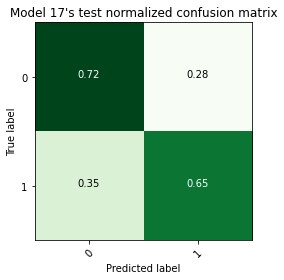

In [441]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Train model on all Train Set and Test Set, with threshold tuning </h6>

In [442]:
min_impurity_decrease = get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test)
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

ModelThreshold=0.409, AP=0.15688 


Train Accuracy 0.7327293318233296
Train Precision 0.8452787428747663
Train Recall 0.7327293318233296
Train F1-score 0.7630908432830956
Train F2-score 0.7368892167391212
Train roc_auc: 0.7582818515534068
              precision    recall  f1-score   support

           0       0.94      0.72      0.82       730
           1       0.37      0.80      0.51       153

    accuracy                           0.73       883
   macro avg       0.66      0.76      0.66       883
weighted avg       0.85      0.73      0.76       883



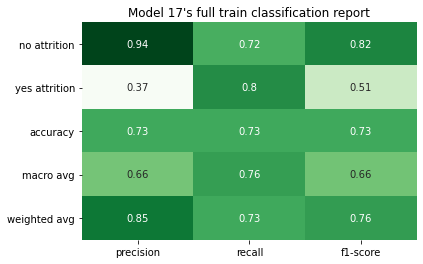

Confusion matrix, without normalization
[[525 205]
 [ 31 122]]


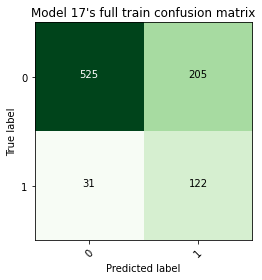

Validation roc_auc: 0.7124006359300478
Validation precision_recall_ap: 0.2685723171748872

Test Accuracy 0.7168949771689498
Validation Precision 0.8347021879826494
Validation Recall 0.7168949771689498
Validation F1-score 0.752816673247679
Validation F2-score 0.724070519791187
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       185
           1       0.32      0.71      0.44        34

    accuracy                           0.72       219
   macro avg       0.62      0.71      0.62       219
weighted avg       0.83      0.72      0.75       219



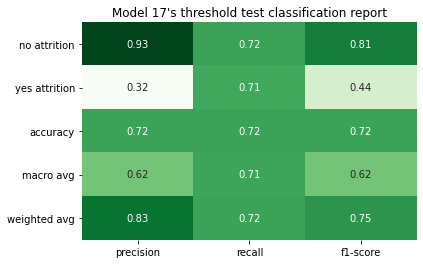

Confusion matrix, without normalization
[[133  52]
 [ 10  24]]


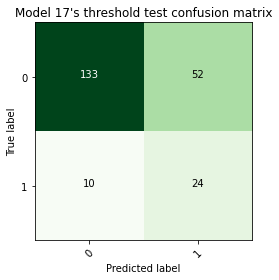

In [444]:
models_u3, y_pred_vals_u3, y_pred_trains_u3, roc_auc_models_u_val3, precision_recall_auc_models_u_val3 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], min_impurity_decrease)    

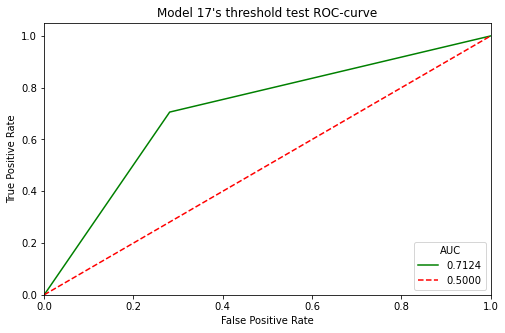

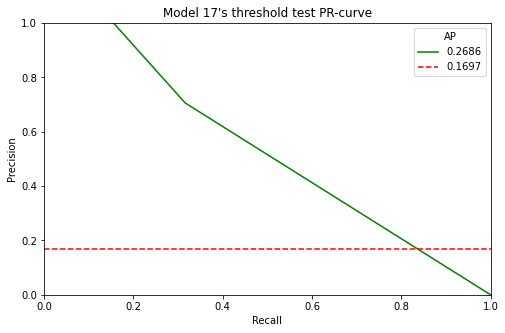

In [445]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[0.71917808 0.28082192]
 [0.20261438 0.79738562]]


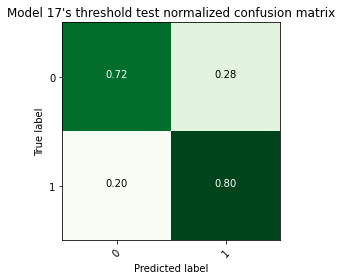

Normalized confusion matrix
[[0.71891892 0.28108108]
 [0.29411765 0.70588235]]


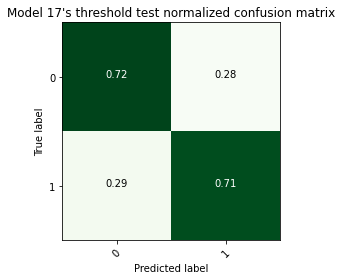

In [446]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u3, yy_train, yy_test,\
                                       y_pred_trains_u3, y_pred_vals_u3)

<h1> OneHot </h1>

In [673]:
data_directory = "../../../data/"
TR_cleaned_file = data_directory + "Cleaned_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "OneHot_Test_HR_Employee_Attrition.csv"

In [674]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_cleaned.shape

(883, 24)

In [675]:
df_ts =  pd.read_csv(TS_file, sep=",") 
df_ts.shape

(219, 24)

In [518]:
# del df_cleaned["OverallSatisfaction"]
df_cleaned.shape

(883, 24)

In [519]:
# del df_ts["OverallSatisfaction"]
df_ts.shape

(219, 24)

In [520]:
criterion='entropy'
max_features='auto'
max_depth=2
min_samples_split=30
min_samples_leaf=80
class_weight='balanced'
model_name = 76
cmap = plt.cm.Blues
color = "blue"

<h6> Train again model on Validation Set </h6>

In [521]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)
print(y.shape)

(883, 23)
(883,)


In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [523]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 0.6877022653721683
Train Precision 0.8024424758304387
Train Recall 0.6877022653721683
Train F1-score 0.7229254542417786
Train F2-score 0.6951536423380008
Train roc_auc: 0.6744609250690418
              precision    recall  f1-score   support

           0       0.91      0.69      0.79       511
           1       0.31      0.65      0.42       107

    accuracy                           0.69       618
   macro avg       0.61      0.67      0.60       618
weighted avg       0.80      0.69      0.72       618



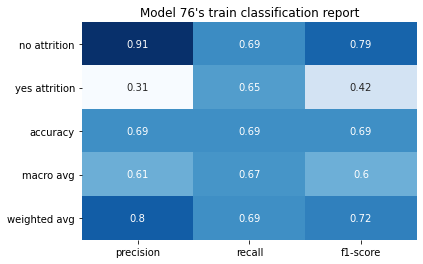

Confusion matrix, without normalization
[[355 156]
 [ 37  70]]


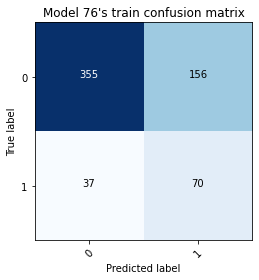

Validation roc_auc: 0.6805141949573159
Validation precision_recall_ap: 0.2719078603922738

Test Accuracy 0.7132075471698113
Validation Precision 0.8042460098264383
Validation Recall 0.7132075471698113
Validation F1-score 0.7429439423807208
Validation F2-score 0.7203917932275312
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       219
           1       0.33      0.63      0.43        46

    accuracy                           0.71       265
   macro avg       0.62      0.68      0.62       265
weighted avg       0.80      0.71      0.74       265



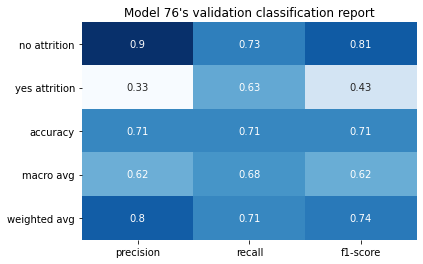

Confusion matrix, without normalization
[[160  59]
 [ 17  29]]


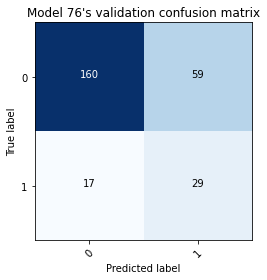

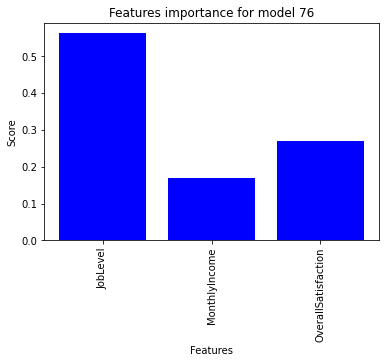

In [601]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         [], -1)    

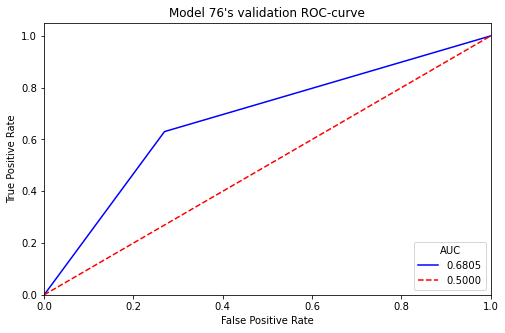

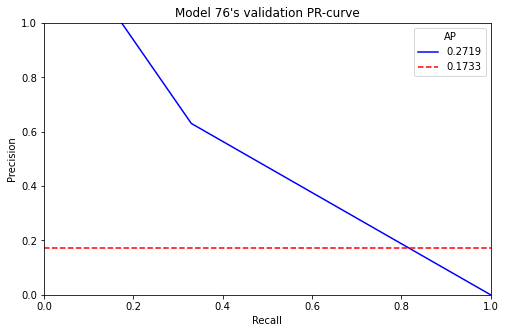

In [602]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[0.69471624 0.30528376]
 [0.34579439 0.65420561]]


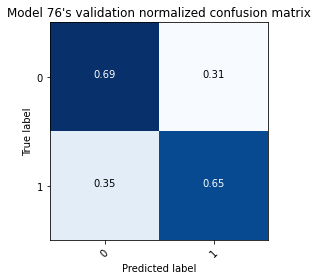

Normalized confusion matrix
[[0.73059361 0.26940639]
 [0.36956522 0.63043478]]


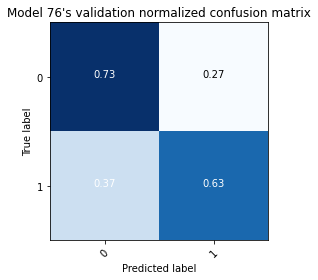

In [608]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

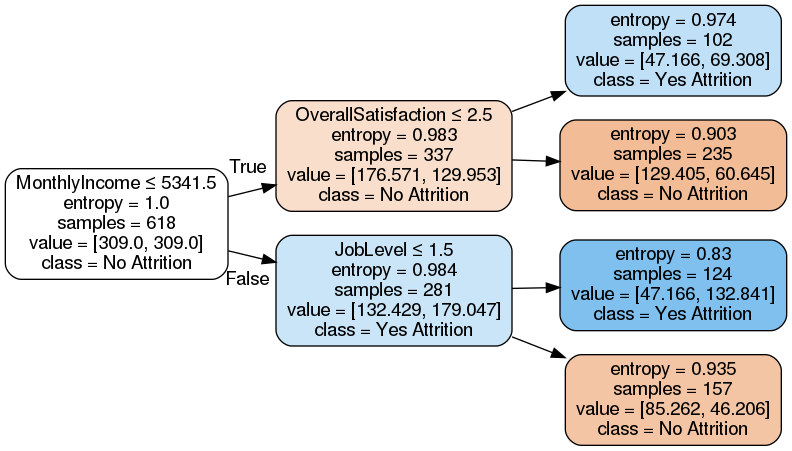

In [604]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=True,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

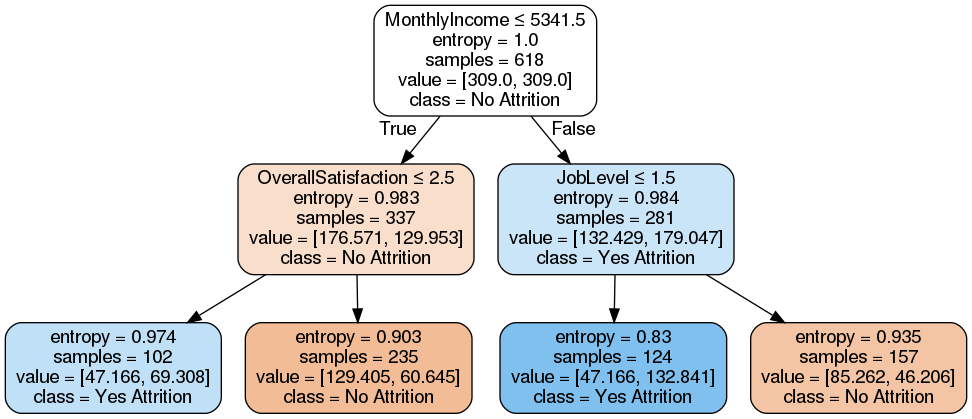

In [605]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=False,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h6> Train model on all Train Set and Test Set </h6>

In [609]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
XX_train = df3.drop('Attrition', axis=1)
print(XX_train.shape)
print(yy_train.shape)

(883, 23)
(883,)


In [610]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
XX_test = df4.drop('Attrition', axis=1)
print(XX_test.shape)
print(yy_test.shape)

(219, 23)
(219,)


In [611]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 0.7304643261608154
Train Precision 0.7887118209574681
Train Recall 0.7304643261608154
Train F1-score 0.752553356412043
Train F2-score 0.7372833896585992
Train roc_auc: 0.648424209866595
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       730
           1       0.33      0.52      0.40       153

    accuracy                           0.73       883
   macro avg       0.61      0.65      0.61       883
weighted avg       0.79      0.73      0.75       883



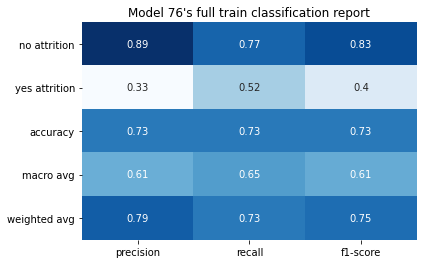

Confusion matrix, without normalization
[[565 165]
 [ 73  80]]


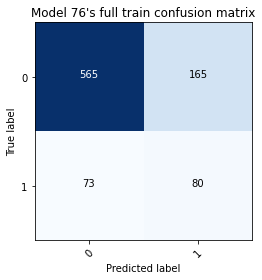

Validation roc_auc: 0.655087440381558
Validation precision_recall_ap: 0.23184156697452427

Test Accuracy 0.7214611872146118
Validation Precision 0.8078492283971735
Validation Recall 0.7214611872146118
Validation F1-score 0.7523352488802847
Validation F2-score 0.7300893253691093
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       185
           1       0.29      0.56      0.38        34

    accuracy                           0.72       219
   macro avg       0.60      0.66      0.60       219
weighted avg       0.81      0.72      0.75       219



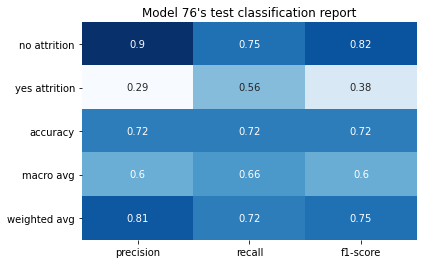

Confusion matrix, without normalization
[[139  46]
 [ 15  19]]


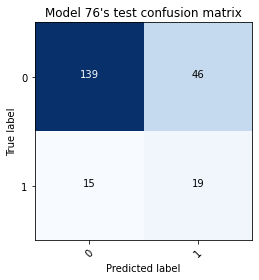

In [637]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], -1)    

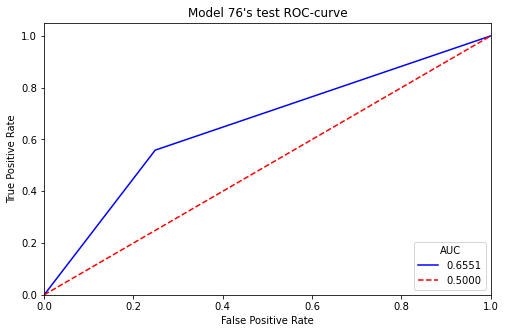

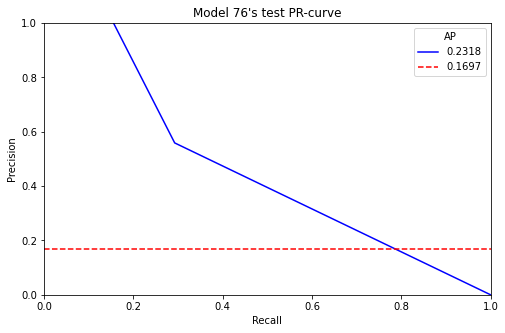

In [638]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[0.7739726  0.2260274 ]
 [0.47712418 0.52287582]]


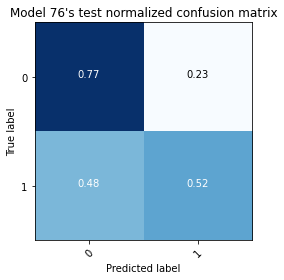

Normalized confusion matrix
[[0.75135135 0.24864865]
 [0.44117647 0.55882353]]


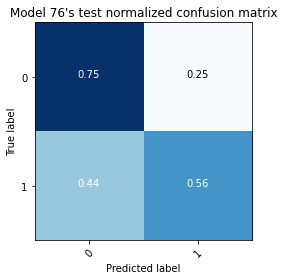

In [639]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Train model on all Train Set and Test Set, with threshold tuning </h6>

In [640]:
min_impurity_decrease = get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test)
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

ModelThreshold=0.374, AP=0.17178 


Train Accuracy 0.7576443941109853
Train Precision 0.7970966694622547
Train Recall 0.7576443941109853
Train F1-score 0.7734064256366731
Train F2-score 0.7628432470284212
Train roc_auc: 0.6622795236816188
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       730
           1       0.36      0.52      0.42       153

    accuracy                           0.76       883
   macro avg       0.62      0.66      0.64       883
weighted avg       0.80      0.76      0.77       883



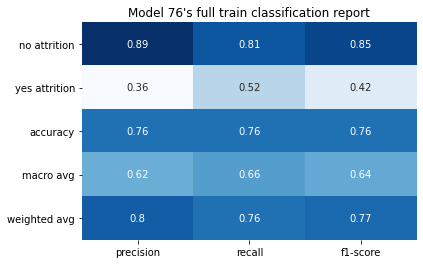

Confusion matrix, without normalization
[[590 140]
 [ 74  79]]


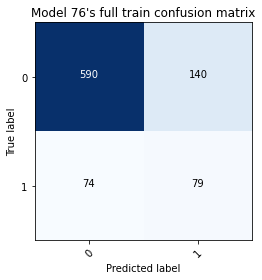

Validation roc_auc: 0.6631955484896661
Validation precision_recall_ap: 0.23974552260144005

Test Accuracy 0.7351598173515982
Validation Precision 0.8116173315207346
Validation Recall 0.7351598173515982
Validation F1-score 0.7629409330022164
Validation F2-score 0.7431309783900614
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       185
           1       0.31      0.56      0.40        34

    accuracy                           0.74       219
   macro avg       0.61      0.66      0.61       219
weighted avg       0.81      0.74      0.76       219



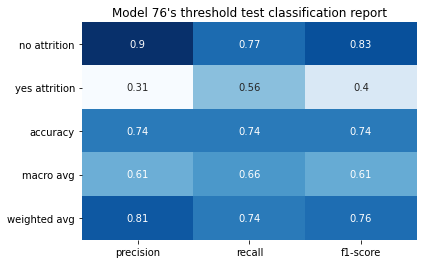

Confusion matrix, without normalization
[[142  43]
 [ 15  19]]


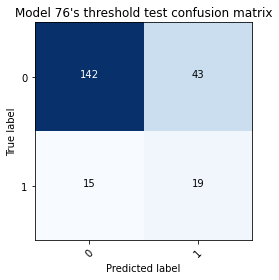

In [660]:
models_u3, y_pred_vals_u3, y_pred_trains_u3, roc_auc_models_u_val3, precision_recall_auc_models_u_val3 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], min_impurity_decrease)    

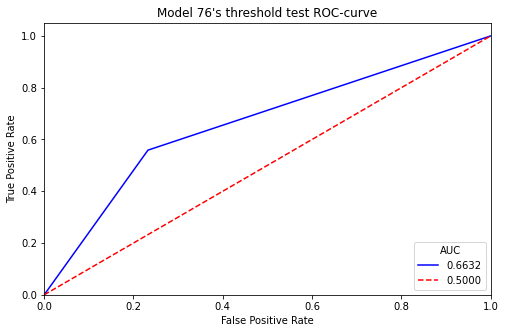

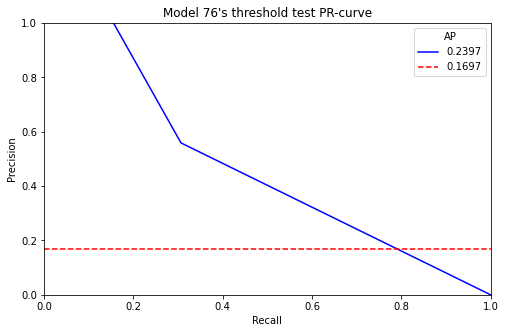

In [661]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[0.80821918 0.19178082]
 [0.48366013 0.51633987]]


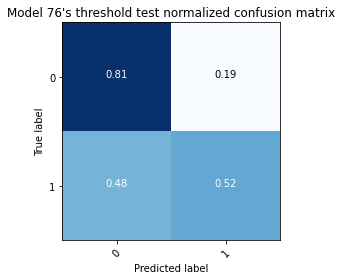

Normalized confusion matrix
[[0.76756757 0.23243243]
 [0.44117647 0.55882353]]


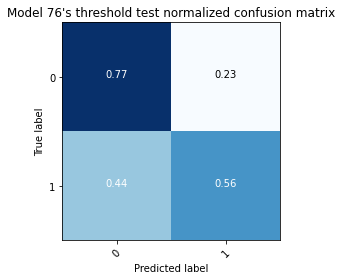

In [662]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u3, yy_train, yy_test,\
                                       y_pred_trains_u3, y_pred_vals_u3)

<h1> OneHot discretized </h1>

In [283]:
data_directory = "../../../data/"
TR_cleaned_file = data_directory + "Discretized_One_Hot_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Discretized_One_Hot_Encoding_Test_HR_Employee_Attrition.csv"

In [284]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_cleaned.shape

(883, 24)

In [285]:
df_ts =  pd.read_csv(TS_file, sep=",") 
df_ts.shape

(219, 24)

In [286]:
"""del df_cleaned["EnvironmentSatisfaction"]
del df_cleaned["JobInvolvement"]
del df_cleaned["JobSatisfaction"]
del df_cleaned["RelationshipSatisfaction"]
del df_cleaned["WorkLifeBalance"]"""
df_cleaned.shape

(883, 24)

In [287]:
"""del df_ts["EnvironmentSatisfaction"]
del df_ts["JobInvolvement"]
del df_ts["JobSatisfaction"]
del df_ts["RelationshipSatisfaction"]
del df_ts["WorkLifeBalance"]"""
df_ts.shape

(219, 24)

In [288]:
criterion='gini'
max_features='auto'
max_depth=6
min_samples_split=60
min_samples_leaf=2
class_weight='balanced'
model_name = 0
cmap = plt.cm.Oranges
color = "orange"

<h6> Train again model on Validation Set </h6>

In [289]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)
print(y.shape)

(883, 23)
(883,)


In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [291]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 0.7734627831715211
Train Precision 0.844252989937389
Train Recall 0.7734627831715211
Train F1-score 0.7952473898183547
Train F2-score 0.7780634666892027
Train roc_auc: 0.7595698374087825
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       511
           1       0.41      0.74      0.53       107

    accuracy                           0.77       618
   macro avg       0.67      0.76      0.69       618
weighted avg       0.84      0.77      0.80       618



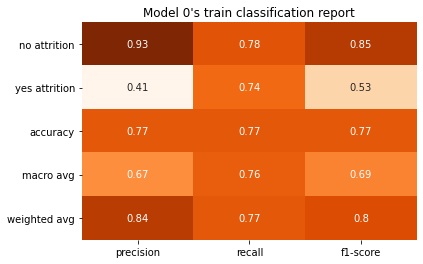

Confusion matrix, without normalization
[[399 112]
 [ 28  79]]


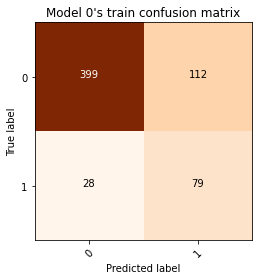

Validation roc_auc: 0.7239924558268811
Validation precision_recall_ap: 0.3063817455505225

Test Accuracy 0.7283018867924528
Validation Precision 0.8265786890609663
Validation Recall 0.7283018867924528
Validation F1-score 0.7576434347323835
Validation F2-score 0.7340234185297767
              precision    recall  f1-score   support

           0       0.92      0.73      0.82       219
           1       0.36      0.72      0.48        46

    accuracy                           0.73       265
   macro avg       0.64      0.72      0.65       265
weighted avg       0.83      0.73      0.76       265



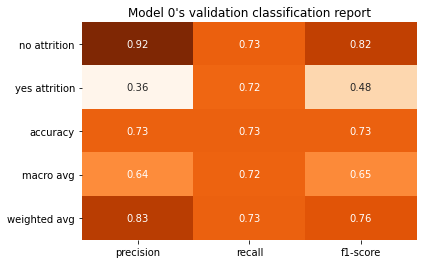

Confusion matrix, without normalization
[[160  59]
 [ 13  33]]


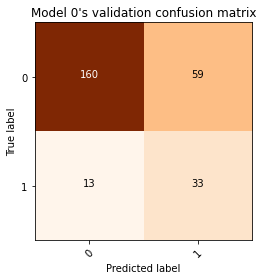

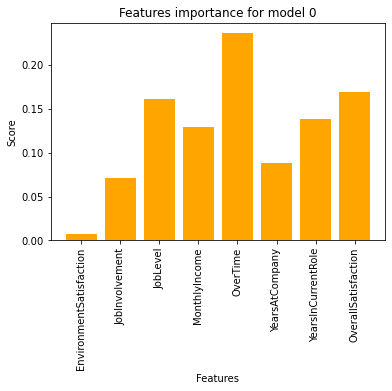

In [298]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         [], -1)    

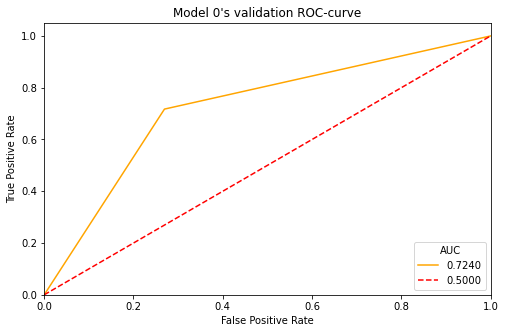

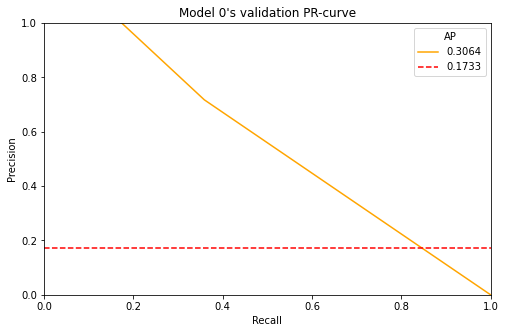

In [300]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.26168224 0.73831776]]


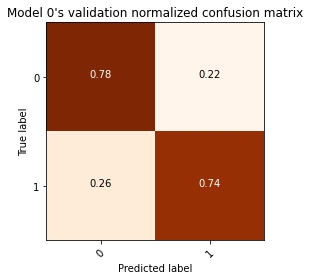

Normalized confusion matrix
[[0.73059361 0.26940639]
 [0.2826087  0.7173913 ]]


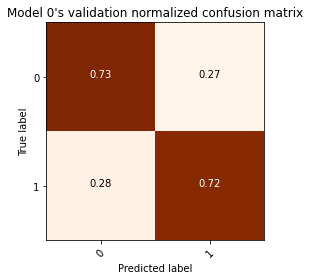

In [301]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

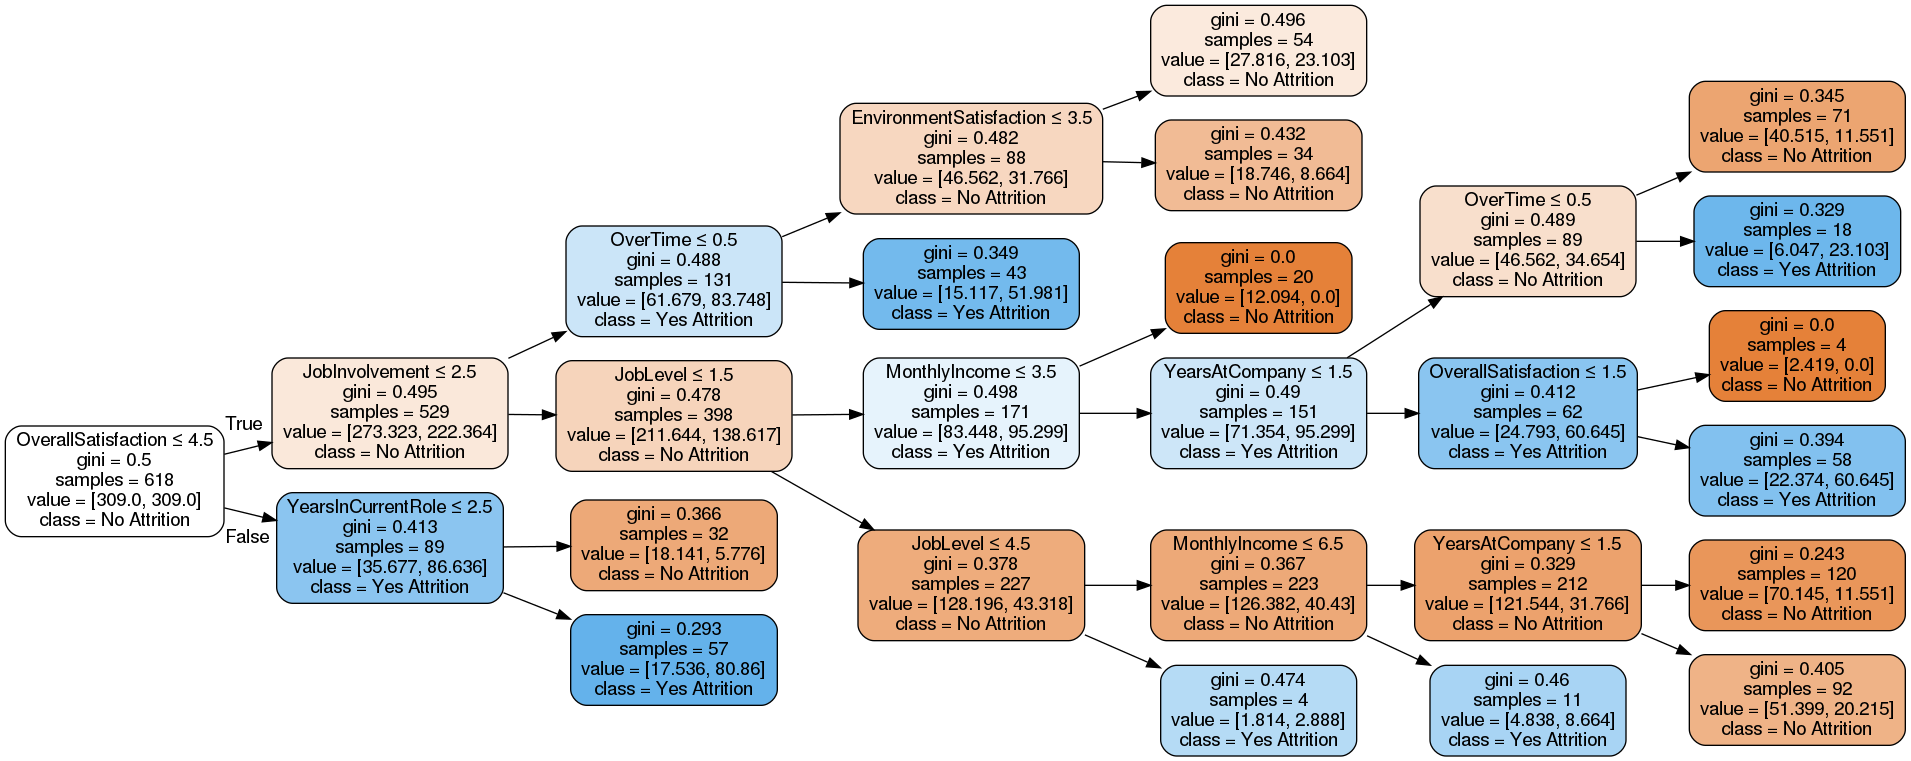

In [302]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=True,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

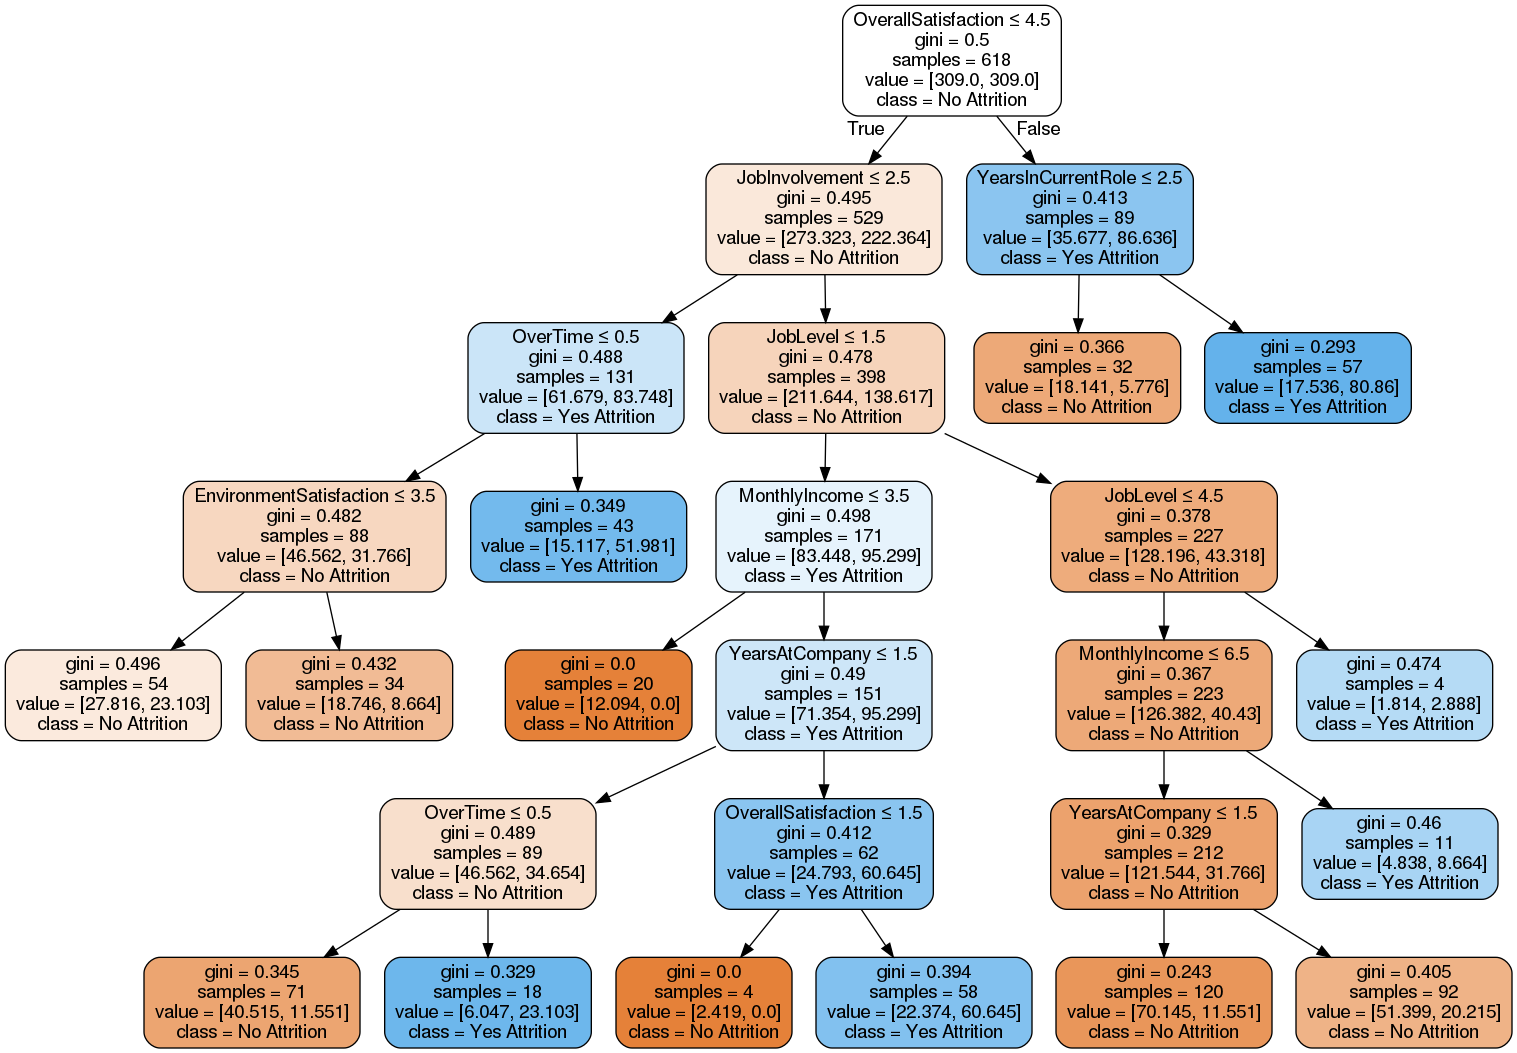

In [303]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=False,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h6> Train model on all Train Set and Test Set </h6>

In [304]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
XX_train = df3.drop('Attrition', axis=1)
print(XX_train.shape)
print(yy_train.shape)

(883, 23)
(883,)


In [305]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
XX_test = df4.drop('Attrition', axis=1)
print(XX_test.shape)
print(yy_test.shape)

(219, 23)
(219,)


In [306]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 0.7916194790486977
Train Precision 0.8464145767946749
Train Recall 0.7916194790486977
Train F1-score 0.8093965512315969
Train F2-score 0.79587684448154
Train roc_auc: 0.7629017817172531
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       730
           1       0.44      0.72      0.54       153

    accuracy                           0.79       883
   macro avg       0.69      0.76      0.70       883
weighted avg       0.85      0.79      0.81       883



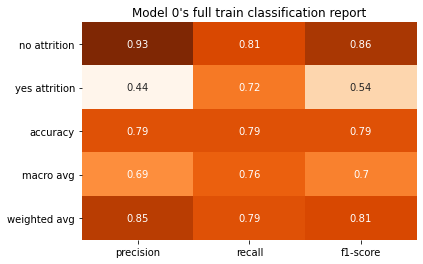

Confusion matrix, without normalization
[[589 141]
 [ 43 110]]


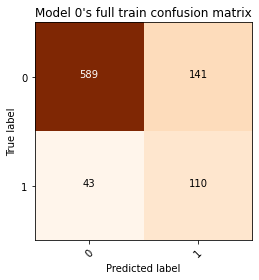

Validation roc_auc: 0.7259141494435613
Validation precision_recall_ap: 0.2842702197606807

Test Accuracy 0.7397260273972602
Validation Precision 0.8401504919930542
Validation Recall 0.7397260273972602
Validation F1-score 0.7711241574255273
Validation F2-score 0.7463933558334989
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       185
           1       0.34      0.71      0.46        34

    accuracy                           0.74       219
   macro avg       0.64      0.73      0.64       219
weighted avg       0.84      0.74      0.77       219



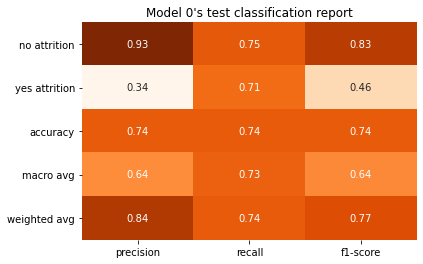

Confusion matrix, without normalization
[[138  47]
 [ 10  24]]


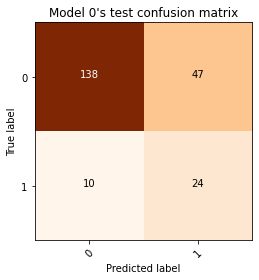

In [312]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], -1)    

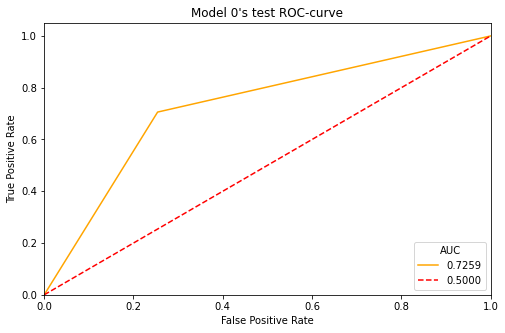

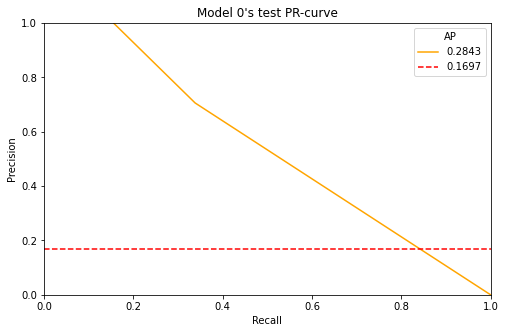

In [313]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[0.80684932 0.19315068]
 [0.28104575 0.71895425]]


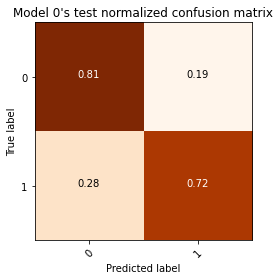

Normalized confusion matrix
[[0.74594595 0.25405405]
 [0.29411765 0.70588235]]


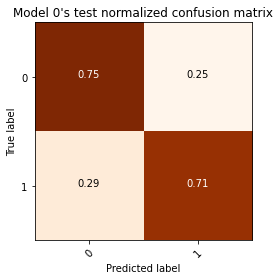

In [314]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Train model on all Train Set and Test Set, with threshold tuning </h6>

In [315]:
min_impurity_decrease = get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test)
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

ModelThreshold=0.705, AP=0.29011 


Train Accuracy 0.7780294450736127
Train Precision 0.85080205221155
Train Recall 0.7780294450736127
Train F1-score 0.7997334730838569
Train F2-score 0.7822490567728951
Train roc_auc: 0.7727639000805802
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       730
           1       0.42      0.76      0.54       153

    accuracy                           0.78       883
   macro avg       0.68      0.77      0.70       883
weighted avg       0.85      0.78      0.80       883



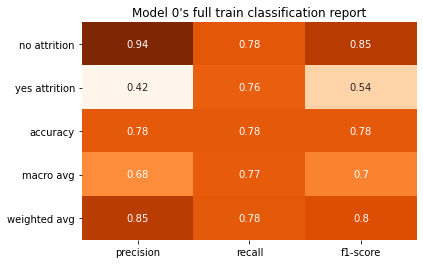

Confusion matrix, without normalization
[[570 160]
 [ 36 117]]


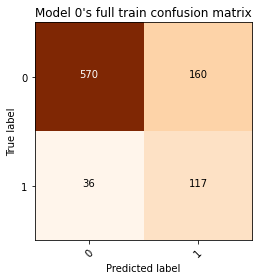

Validation roc_auc: 0.7463434022257552
Validation precision_recall_ap: 0.32319012680775266

Test Accuracy 0.7945205479452054
Validation Precision 0.8500345655276361
Validation Recall 0.7945205479452054
Validation F1-score 0.8136778936984219
Validation F2-score 0.7995863011495341
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       185
           1       0.40      0.68      0.51        34

    accuracy                           0.79       219
   macro avg       0.67      0.75      0.69       219
weighted avg       0.85      0.79      0.81       219



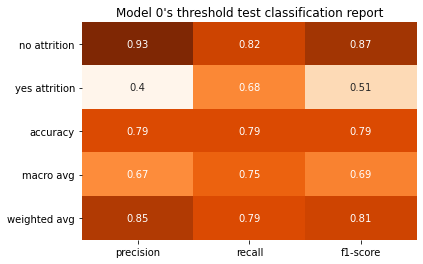

Confusion matrix, without normalization
[[151  34]
 [ 11  23]]


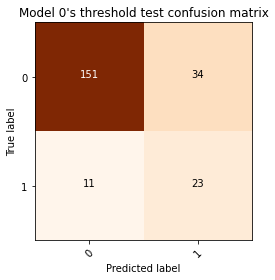

In [359]:
models_u3, y_pred_vals_u3, y_pred_trains_u3, roc_auc_models_u_val3, precision_recall_auc_models_u_val3 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], min_impurity_decrease)    

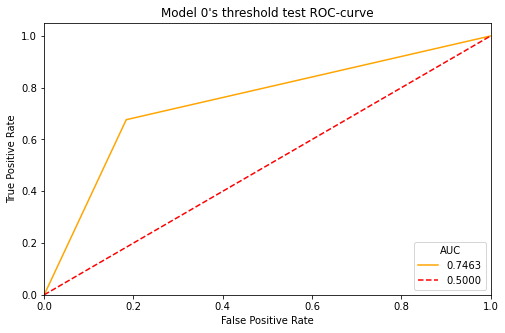

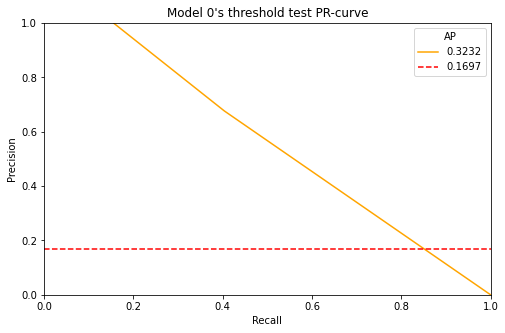

In [360]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.23529412 0.76470588]]


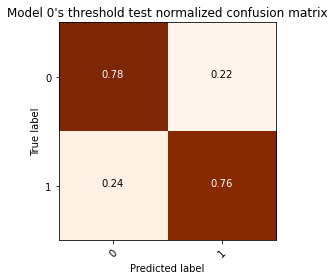

Normalized confusion matrix
[[0.81621622 0.18378378]
 [0.32352941 0.67647059]]


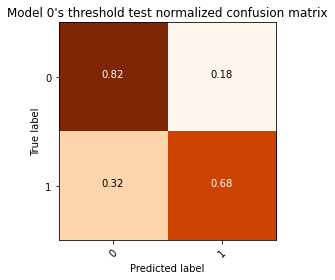

In [361]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u3, yy_train, yy_test,\
                                       y_pred_trains_u3, y_pred_vals_u3)

<h1> Numerical discretized </h1>

In [678]:
data_directory = "../../../data/"
TR_cleaned_file = data_directory + "Discretized_Numerical_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Discretized_Numerical_Encoding_Test_HR_Employee_Attrition.csv"

In [679]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 
df_cleaned.shape

(883, 24)

In [680]:
df_ts =  pd.read_csv(TS_file, sep=",") 
df_ts.shape

(219, 24)

In [23]:
# del df_cleaned["OverallSatisfaction"]
df_cleaned.shape

(883, 24)

In [24]:
# del df_ts["OverallSatisfaction"]
df_ts.shape

(219, 24)

In [25]:
criterion='gini'
max_features='sqrt'
max_depth=15
min_samples_split=90
min_samples_leaf=10
class_weight='balanced'
model_name = 31
cmap = plt.cm.spring_r
color = "fuchsia"

<h6> Train again model on Validation Set </h6>

In [26]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)
print(y.shape)

(883, 23)
(883,)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [164]:
type_flag1 = "train"
type_flag2 = "validation"
no_skill = len(y[y==1]) / len(y)

Train Accuracy 0.7491909385113269
Train Precision 0.8147400905261419
Train Recall 0.7491909385113269
Train F1-score 0.771803645885307
Train F2-score 0.755239646494466
Train roc_auc: 0.7005596503100023
              precision    recall  f1-score   support

           0       0.91      0.77      0.84       511
           1       0.37      0.63      0.46       107

    accuracy                           0.75       618
   macro avg       0.64      0.70      0.65       618
weighted avg       0.81      0.75      0.77       618



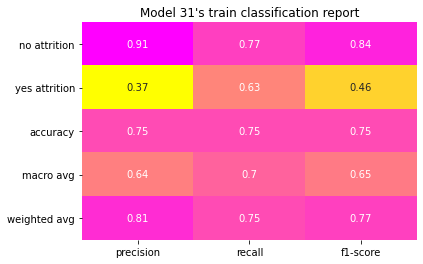

Confusion matrix, without normalization
[[396 115]
 [ 40  67]]


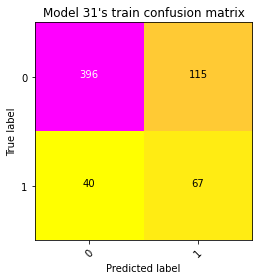

Validation roc_auc: 0.7079114552312884
Validation precision_recall_ap: 0.30471158412849186

Test Accuracy 0.7584905660377359
Validation Precision 0.8183178070963572
Validation Recall 0.7584905660377359
Validation F1-score 0.7793053255945125
Validation F2-score 0.7641468550052126
              precision    recall  f1-score   support

           0       0.91      0.79      0.84       219
           1       0.38      0.63      0.48        46

    accuracy                           0.76       265
   macro avg       0.65      0.71      0.66       265
weighted avg       0.82      0.76      0.78       265



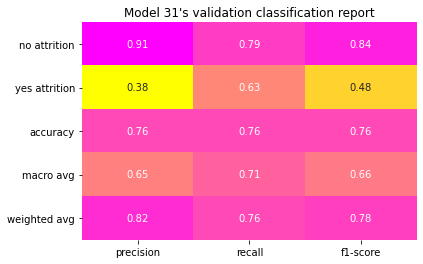

Confusion matrix, without normalization
[[172  47]
 [ 17  29]]


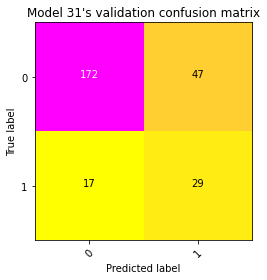

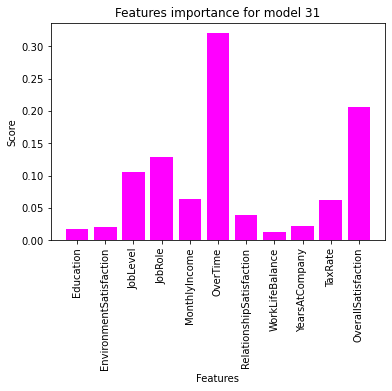

In [216]:
models_u, y_pred_vals_u, y_pred_trains_u, roc_auc_models_u_val, precision_recall_auc_models_u_val = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, X_train, y_train, X_test, y_test,\
                         [], -1)    

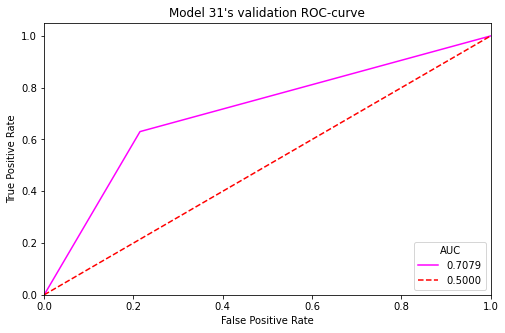

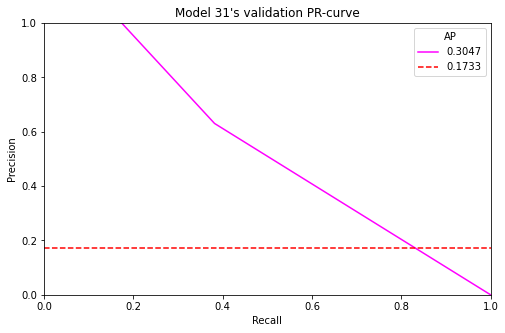

In [217]:
draw_roc_and_pr_curves(model_name, y_test, y_pred_vals_u, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val, roc_auc_models_u_val)

Normalized confusion matrix
[[0.77495108 0.22504892]
 [0.37383178 0.62616822]]


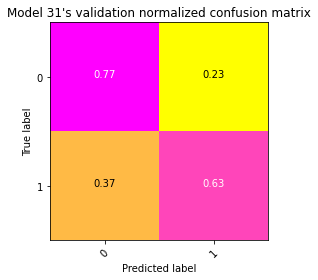

Normalized confusion matrix
[[0.78538813 0.21461187]
 [0.36956522 0.63043478]]


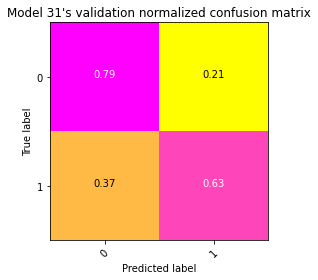

In [218]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u, y_train, y_test,\
                                       y_pred_trains_u, y_pred_vals_u)

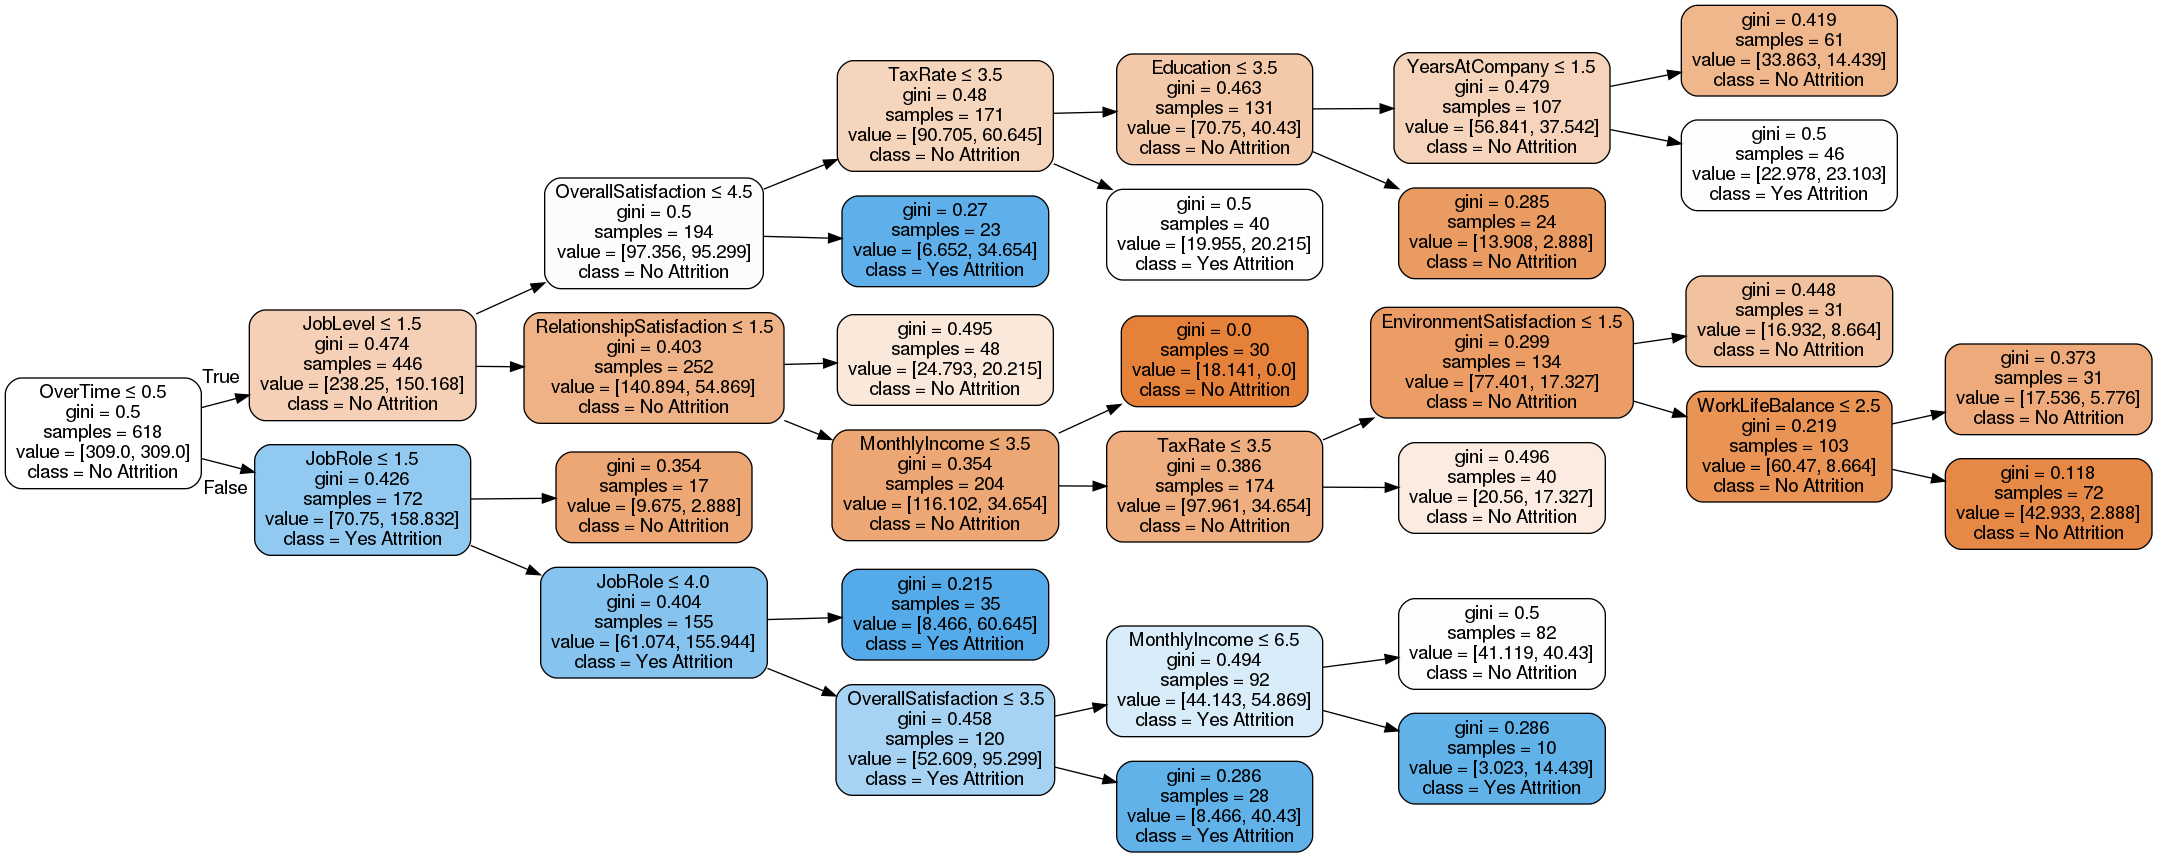

In [219]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=True,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

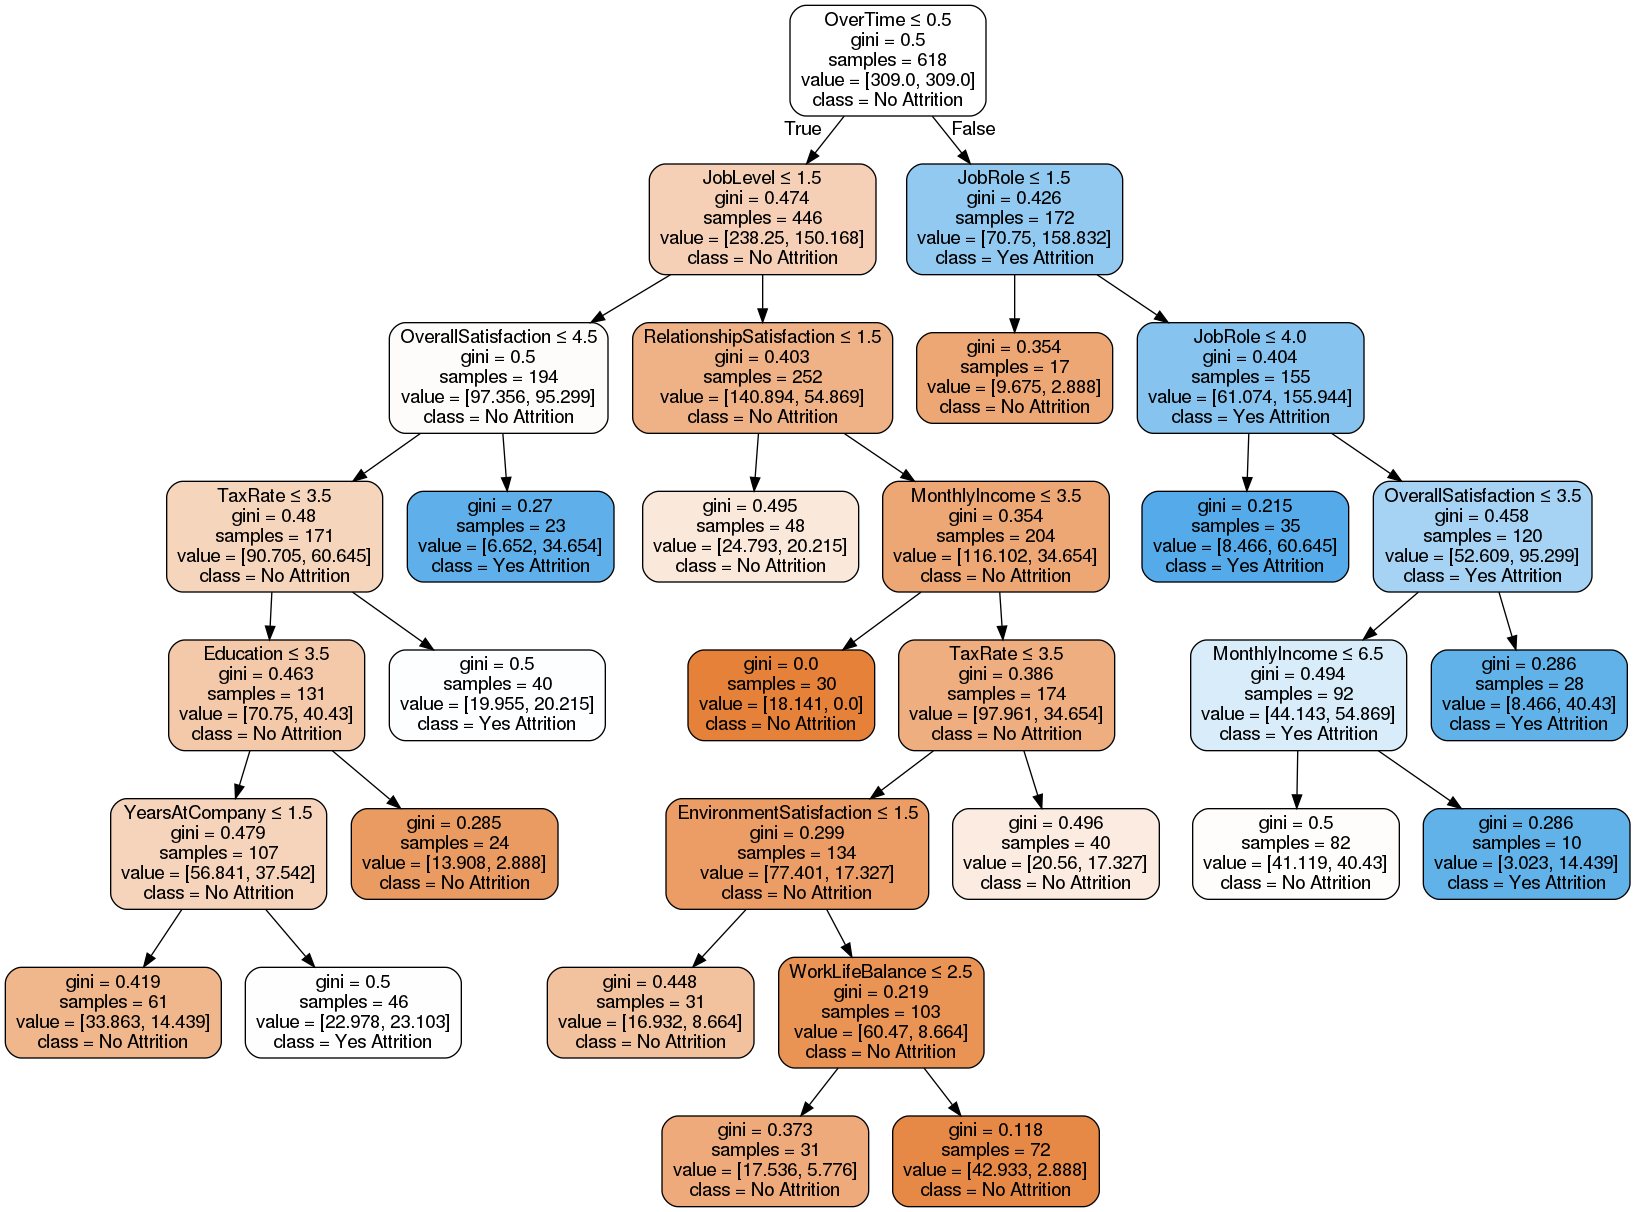

In [220]:
# draw best model's decision tree
dot_data = tree.export_graphviz(models_u[0], out_file=None,
                            feature_names=list(X.columns),
                            class_names=['Yes Attrition' if x == 1 
                                         else 'No Attrition' for x in models_u[0].classes_],  
                            filled=True, rounded=True, rotate=False,
                            special_characters=True)
                            #, max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h6> Train model on all Train Set and Test Set </h6>

In [55]:
yy_train = df_cleaned['Attrition']
df3 = df_cleaned.copy()
XX_train = df3.drop('Attrition', axis=1)
print(XX_train.shape)
print(yy_train.shape)

(883, 23)
(883,)


In [56]:
yy_test = df_ts['Attrition']
df4 = df_ts.copy()
XX_test = df4.drop('Attrition', axis=1)
print(XX_test.shape)
print(yy_test.shape)

(219, 23)
(219,)


In [57]:
type_flag1 = "full train"
type_flag2 = "test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

Train Accuracy 0.7372593431483578
Train Precision 0.8435357791355861
Train Recall 0.7372593431483578
Train F1-score 0.7666088572917971
Train F2-score 0.7416805001225774
Train roc_auc: 0.7558554928820844
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       730
           1       0.38      0.78      0.51       153

    accuracy                           0.74       883
   macro avg       0.66      0.76      0.66       883
weighted avg       0.84      0.74      0.77       883



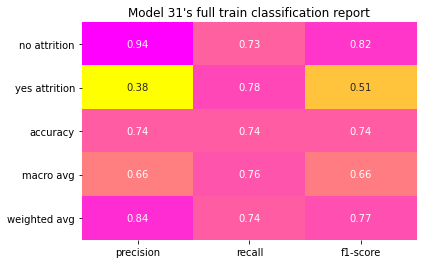

Confusion matrix, without normalization
[[531 199]
 [ 33 120]]


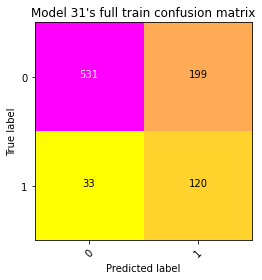

Validation roc_auc: 0.7271065182829889
Validation precision_recall_ap: 0.2798277467898741

Test Accuracy 0.7214611872146118
Validation Precision 0.8416146526314383
Validation Recall 0.7214611872146118
Validation F1-score 0.7570986847095932
Validation F2-score 0.7280236467000889
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       185
           1       0.32      0.74      0.45        34

    accuracy                           0.72       219
   macro avg       0.63      0.73      0.63       219
weighted avg       0.84      0.72      0.76       219



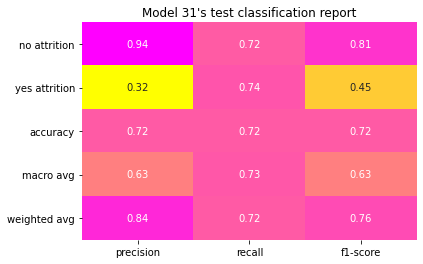

Confusion matrix, without normalization
[[133  52]
 [  9  25]]


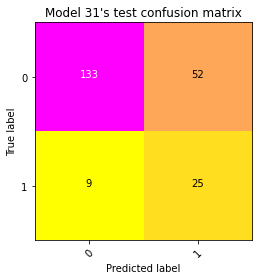

In [95]:
models_u2, y_pred_vals_u2, y_pred_trains_u2, roc_auc_models_u_val2, precision_recall_auc_models_u_val2 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], -1)    

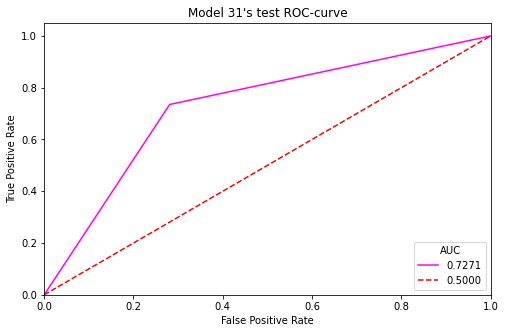

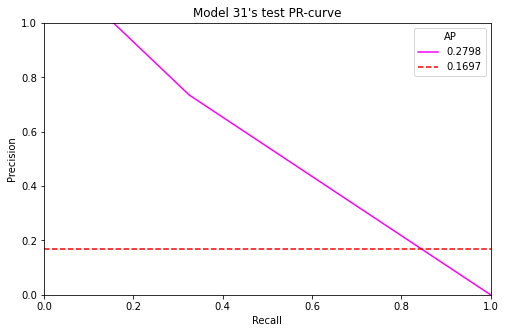

In [281]:

draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u2, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val2, roc_auc_models_u_val2)

Normalized confusion matrix
[[0.72739726 0.27260274]
 [0.21568627 0.78431373]]


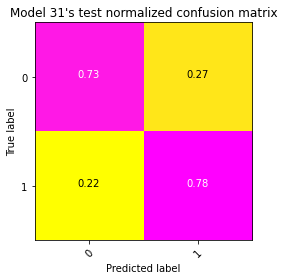

Normalized confusion matrix
[[0.71891892 0.28108108]
 [0.26470588 0.73529412]]


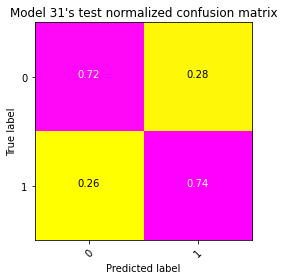

In [97]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u2, yy_train, yy_test,\
                                       y_pred_trains_u2, y_pred_vals_u2)

<h6> Train model on all Train Set and Test Set, with threshold tuning </h6>

In [221]:
min_impurity_decrease = get_model_thresholds(models_u2[0], XX_train, yy_train, XX_test, yy_test)
type_flag1 = "full train"
type_flag2 = "threshold test"
no_skill = (len(yy_train[yy_train==1]) + len(yy_test[yy_test==1]))/ (len(yy_train) + len(yy_test))

ModelThreshold=0.628, AP=0.22699 


Train Accuracy 0.6987542468856173
Train Precision 0.826644400592213
Train Recall 0.6987542468856173
Train F1-score 0.7339183950734832
Train F2-score 0.704062166292873
Train roc_auc: 0.7196526099024083
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       730
           1       0.34      0.75      0.46       153

    accuracy                           0.70       883
   macro avg       0.63      0.72      0.63       883
weighted avg       0.83      0.70      0.73       883



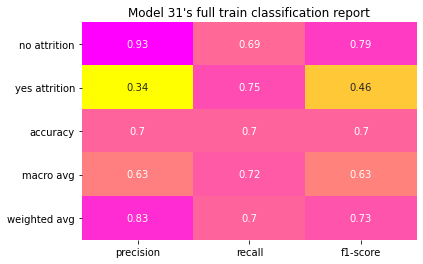

Confusion matrix, without normalization
[[502 228]
 [ 38 115]]


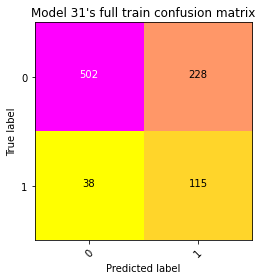

Validation roc_auc: 0.7649443561208267
Validation precision_recall_ap: 0.33287927042963306

Test Accuracy 0.7853881278538812
Validation Precision 0.8576209432373816
Validation Recall 0.7853881278538812
Validation F1-score 0.8083435592307584
Validation F2-score 0.7904776092219087
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       185
           1       0.40      0.74      0.52        34

    accuracy                           0.79       219
   macro avg       0.67      0.76      0.69       219
weighted avg       0.86      0.79      0.81       219



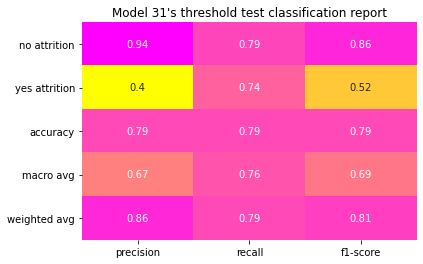

Confusion matrix, without normalization
[[147  38]
 [  9  25]]


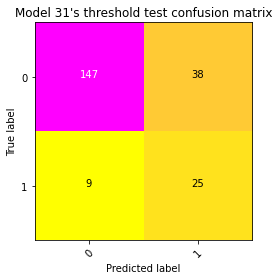

In [271]:
models_u3, y_pred_vals_u3, y_pred_trains_u3, roc_auc_models_u_val3, precision_recall_auc_models_u_val3 = \
        fit_and_transform(model_name, type_flag1, type_flag2, cmap, color, XX_train, yy_train, XX_test, yy_test,\
                         [], min_impurity_decrease)    

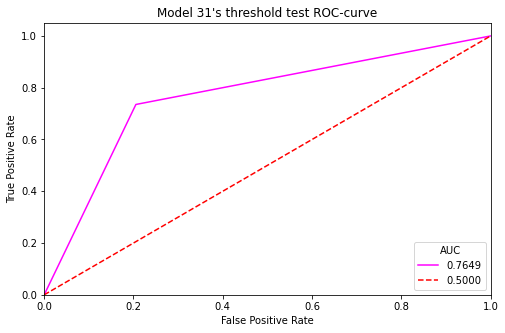

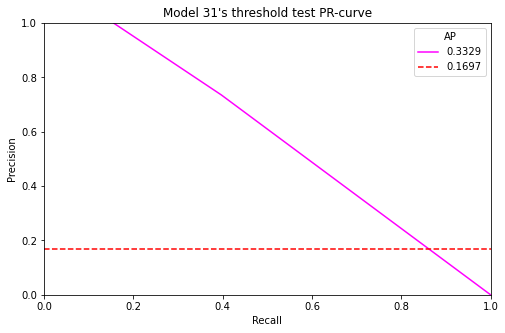

In [280]:
draw_roc_and_pr_curves(model_name, yy_test, y_pred_vals_u3, no_skill, type_flag2, color, \
                       precision_recall_auc_models_u_val3, roc_auc_models_u_val3)

Normalized confusion matrix
[[0.68767123 0.31232877]
 [0.24836601 0.75163399]]


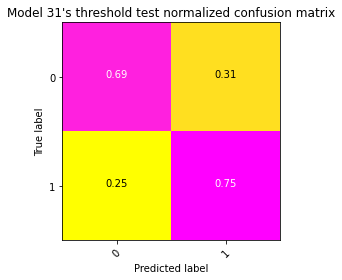

Normalized confusion matrix
[[0.79459459 0.20540541]
 [0.26470588 0.73529412]]


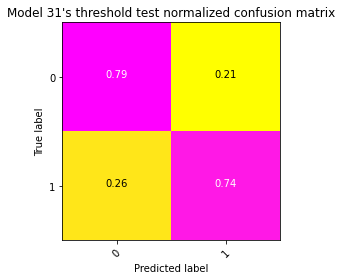

In [274]:
draw_normalized_confusion_matrises(model_name, type_flag1, type_flag2, cmap, models_u3, yy_train, yy_test,\
                                       y_pred_trains_u3, y_pred_vals_u3)

<h2>Validarion curves</h2>

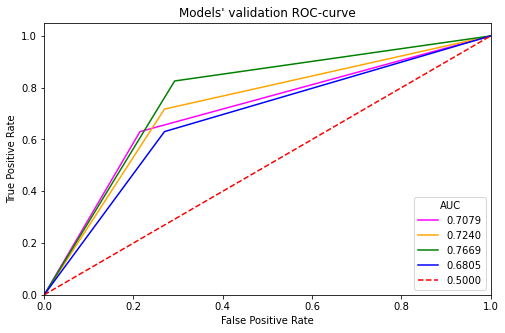

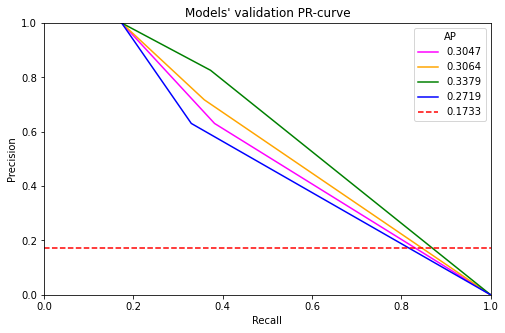

In [663]:
draw_multiple_roc_and_ap_curves("validation")

<h2> Test curves </h2>

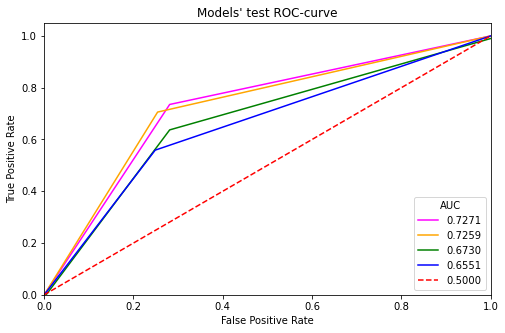

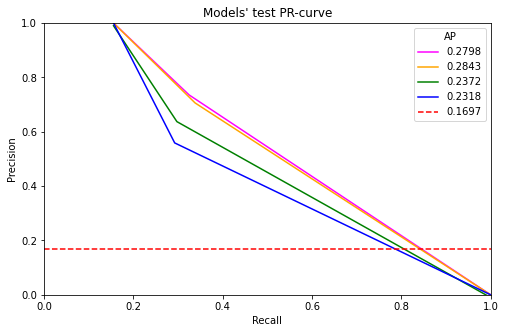

In [664]:
draw_multiple_roc_and_ap_curves("test")

<h2> Threshold test curves </h2>

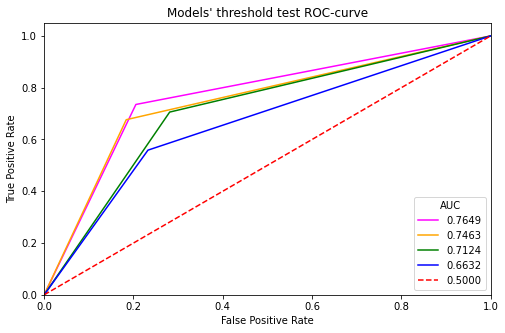

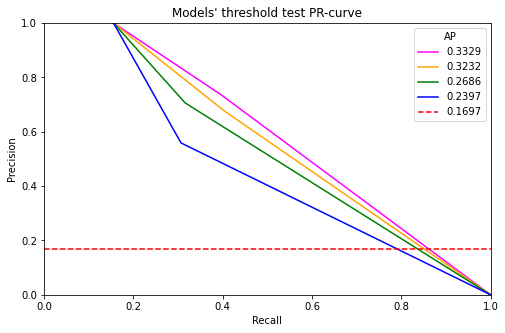

In [665]:
draw_multiple_roc_and_ap_curves("threshold test")

<h2> Save global_info on file</h2> 

In [692]:
import pickle 

with open(data_directory + 'global_info_evaluation3.pickle', 'wb') as handle:
    pickle.dump(global_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [694]:
with open(data_directory + 'global_info_evaluation3.pickle', 'rb') as handle:
    tmp_global_info = pickle.load(handle)